In [39]:
import pandas as pd
import xarray as xr
import requests
import matplotlib.pyplot as plt
import shapely

## Section 1: Storm Reports ##

In [2]:
#Gets wind report on given date as a pandas dataframe
def get_wind_report(datetime):
    date = datetime.strftime("%y%m%d")
    df = request_wind_report_df(date)    
    df = add_datetime(df, datetime)
    return df

#Helper functions 
#Requests the wind report from the NOAA website and cleans up the data
def request_wind_report_df(date):
    #Actual request
    link = generate_link(date)
    data = requests.get(link)
    #Turns csv string into dataFrame
    csv_string = data.text
    data = [row.split(',') for row in csv_string.split('\n')]
    data.pop(-1)
    columns = data.pop(0)
    data.pop(0)
    #Returns dataframe 
    df = pd.DataFrame(data, columns=columns)
    df["Lat"] = df["Lat"].astype("float")
    df["Lon"] = df["Lon"].astype("float")
    return df

#Adds date time column to the dataframe
def add_datetime(df, datetime):
    time = df["Time"]
    #TODO: Rename foo function
    df["datetime"] = [foo(datetime, t) for t in time]
    df['datetime'] = pd.to_datetime(df["datetime"])
    #Removes Time column
    df.drop(columns=["Time"], inplace=True)
    return df 

#Corrects the date for a given report
#TODO: Rename this function
def foo(datetime, time):
    day = datetime.day if int(time[0] + time[1]) >= 12 else (datetime + pd.Timedelta(days = 1)).day
    dt = pd.Timestamp(year=datetime.year, month=datetime.month,
                                   day=day, hour=int(time[0] + time[1]),
                                  minute = int(time[2] + time[3]))
    return dt



#Generates link to csv download of wind report on given date. Date format "yymmdd"
def generate_link(date):
    return f'https://www.spc.noaa.gov/climo/reports/{date}_rpts_wind.csv'



In [3]:
#Returns pandas dataframe with wind reports for given date range
def get_weather_reports(start_date, end_date):    
    i = 0
    for date in generate_days(start_date, end_date):
        df = get_wind_report(date)
        if i == 0:
            big_df = df
            i += 1
        else :
            big_df = pd.concat([big_df, df])
    big_df.reset_index(inplace=True)
    return big_df

#Helper function
#Generates dates in format "yymmdd"
def generate_days(start_date, end_date):
    
    days = pd.period_range(start=start_date, end=end_date)
    # days = [day.strftime("%y%m%d") for day in days]
    return days


In [4]:
#Applies filters to the storm report dataset
def filter_reports(df, center_event, distance, hours):
    spatially_filtered = spatial_filter(df, center_event["Lat"], center_event["Lon"], distance)
    temporally_filtered = temporal_filter(spatially_filtered, hours,center_event["datetime"], )
    return temporally_filtered

#Filters the storm reports so that only the ones that are +- hours from the given date time
def temporal_filter(df, hours, date_time):
    filtered_df = df[df["datetime"] >= (date_time - pd.Timedelta(hours=hours))]
    time_filtered_events = filtered_df[filtered_df["datetime"] <= (date_time + pd.Timedelta(hours=hours))]
    return time_filtered_events

#Filters storm reports so that only the ones that are +- distance from given lat/lon
#TODO: Enhance so that we can give the distance in kilometers
def spatial_filter(df, lat, lon, distance):
    lat_filtered_df = latitude_filter(df, lat, distance)
    filtered_df = longitude_filter(lat_filtered_df, lon, distance)
    return filtered_df

#Helper functions for the spatial filter
def latitude_filter(df, lat, distance):
    val = lat + distance
    lat_filtered = df[df["Lat"] <= val]
    lat_filtered = lat_filtered[lat_filtered["Lat"] >= lat - distance]
    return lat_filtered

def longitude_filter(df, lon, distance):
    lon_filtered = df[df["Lon"] <= lon + distance]
    lon_filtered = lon_filtered[lon_filtered["Lon"] >= lon - distance]
    return lon_filtered
    

In [5]:
#Wind reports for June 7 2023
get_wind_report(pd.Timestamp(year=2023, month=6, day=7))

Speed           Location       County State    Lat     Lon  \
0    UNK         3 NE Reese       Warren    GA  33.37  -82.55   
1    UNK        2 NNE Reese       Warren    GA  33.37  -82.56   
2    UNK  2 WSW Franklinton         Bibb    GA  32.79  -83.57   
3    UNK         3 NNE Cope   Orangeburg    SC  33.42  -80.98   
4    UNK  4 SW Logan Center  Grand Forks    ND  47.77  -97.87   
..   ...                ...          ...   ...    ...     ...   
71    59       Laughlin AFB    Val Verde    TX  29.36 -100.78   
72   UNK       2 NNE Bergen      Jackson    MN  43.82  -94.99   
73   UNK         5 S Bergen      Jackson    MN  43.72  -95.00   
74   UNK        3 NE Harris      Osceola    IA  43.48  -95.39   
75   UNK         San Benito      Cameron    TX  26.14  -97.64   

                                             Comments            datetime  
0   Trees and powerlines down at Ricketson Road ne... 2023-06-07 19:37:00  
1   Trees and powerlines down on Little Briar Cree... 2023-06-07 19:37:00  
2   Trained spotter reports that a microburst occu... 2023-06-07 19:38:00  
3   Trees and power lines down at Shillings Bridge... 2023-06-07 20:12:00  
4   Corrects previous tstm wnd dmg report from 4 S... 2023-06-07 20:13:00  
..                                                ...                 ...  
71                                              (EWX) 2023-06-08 06:23:00  
72  A large cottonwood tree was uprooted. Grain au... 2023-06-08 07:03:00  
73  Ten power poles snapped off for a half mile we... 2023-06-08 07:14:00  
74  Grain bin and large trees damaged by thunderst... 2023-06-08 08:57:00  
75  Public relayed via social media that RV jack w... 2023-06-08 11:50:00  

[76 rows x 8 columns]

Generates wind reports for dates in a given range 

In [6]:
#Generates wind reports until the most recent day
start_date = pd.Timestamp(year=2023, month=5, day=8)
end_date = pd.Timestamp(year=2023, month=6, day=14)
reports = get_weather_reports(start_date, end_date)
reports 

index Speed                 Location     County State    Lat     Lon  \
0         0   UNK         4 NNW BEVIL OAKS     HARDIN    TX  30.22  -94.29   
1         1   UNK          3 WNW LUMBERTON     HARDIN    TX  30.27  -94.25   
2         2   UNK            3 NW LEWISTON  NEZ PERCE    ID  46.42 -117.03   
3         3   UNK            4 NW BEAUMONT  JEFFERSON    TX  30.14  -94.18   
4         4    59        3 NNW BRIDGE CITY     ORANGE    TX  30.08  -93.87   
...     ...   ...                      ...        ...   ...    ...     ...   
2491    401   UNK  1 E Hwy 231 Pea River B       Dale    AL  31.59  -85.77   
2492    402   UNK                Abbeville      Henry    AL  31.57  -85.25   
2493    403   UNK                   Coates      Henry    AL  31.73  -85.15   
2494    404   UNK      2 WSW Cedar Springs      Early    GA  31.17  -85.06   
2495    405   UNK            6 SE Bellview      Baker    GA  31.11  -84.52   

                                               Comments            datetime  
0     HARDIN 911 REPORTS POSSIBLE TORNADO TOUCHED DO... 2023-05-08 20:10:00  
1     NUMEROUS POWER OUTAGES REPORTED IN AND AROUND ... 2023-05-08 20:25:00  
2     DELAYED REPORT FROM MAY 8TH. GUSTY WINDS FROM ... 2023-05-08 20:30:00  
3                    SOFTWOOD TREE SPLIT IN HALF. (LCH) 2023-05-08 20:42:00  
4     MESONET REPORTS THUNDERSTORM WIND GUST OF 59 M... 2023-05-08 21:19:00  
...                                                 ...                 ...  
2491  Dispatch received a call of trees and powerlin... 2023-06-15 08:48:00  
2492  Multiple reports of trees and power lines down... 2023-06-15 09:20:00  
2493  Multiple reports of trees and power lines down... 2023-06-15 09:20:00  
2494  Large tree limbs were down on Highway 273 at H... 2023-06-15 10:00:00  
2495  Large tree limbs were down on Highway 253 near... 2023-06-15 10:25:00  

[2496 rows x 9 columns]

Deals with the filtering of storm report data. Can filter spatially and temporally. 

In [7]:
report = reports[reports['Lat'] == 32.32]
report = report.loc[1439]

In [8]:
spatial_filter(reports, report["Lat"],report["Lon"], 1)

index Speed               Location   County State    Lat     Lon  \
226      31   UNK         1 NE SEAGRAVES   GAINES    TX  32.95 -102.55   
227      32    80        1 WSW SEAGRAVES   GAINES    TX  32.94 -102.57   
293       4    60             GARDENDALE    ECTOR    TX  32.02 -102.37   
333      44    62           5 SSW GRAHAM    GARZA    TX  33.08 -101.52   
705      14    62             1 S LAMESA   DAWSON    TX  32.73 -101.96   
719      28    59  MIDLAND INTERNATIONAL  MIDLAND    TX  31.94 -102.19   
752       8    71              3 NW WINK  WINKLER    TX  31.78 -103.20   
822      34   UNK            1 WNW LAHEY    TERRY    TX  33.13 -102.36   
823      35    65         2 S BROWNFIELD    TERRY    TX  33.15 -102.27   
824      36    59      6 WNW DENVER CITY   YOAKUM    TX  32.99 -102.94   
825      37    68        1 WSW SEAGRAVES   GAINES    TX  32.94 -102.57   
826      38    61           2 SSE LAMESA   DAWSON    TX  32.71 -101.94   
868       0    79      6 WNW DENVER CITY   YOAKUM    TX  32.99 -102.94   
869       1    58         2 S BROWNFIELD    TERRY    TX  33.15 -102.27   
929       7    65             19 WNW Jal      Lea    NM  32.19 -103.51   
934      12   UNK         6 NNW Monument      Lea    NM  32.70 -103.32   
935      13   UNK          7 NW Monument      Lea    NM  32.70 -103.35   
936      14   UNK             12 W Hobbs      Lea    NM  32.73 -103.37   
937      15   UNK          8 NW Monument      Lea    NM  32.71 -103.35   
938      16   UNK          8 NW Monument      Lea    NM  32.71 -103.36   
940      18   UNK                  Hobbs      Lea    NM  32.73 -103.16   
942      20   UNK       4 NW Humble City      Lea    NM  32.83 -103.27   
943      21   UNK       7 NW Humble City      Lea    NM  32.86 -103.31   
944      22   UNK          4 S Lovington      Lea    NM  32.89 -103.35   
945      23   UNK        6 SSE Lovington      Lea    NM  32.88 -103.30   
947      25   UNK        5 ESE Lovington      Lea    NM  32.92 -103.27   
948      26   UNK        5 ESE Lovington      Lea    NM  32.93 -103.27   
949      27   UNK        4 ESE Lovington      Lea    NM  32.93 -103.28   
950      28   UNK          4 E Lovington      Lea    NM  32.94 -103.27   
951      29   UNK          5 E Lovington      Lea    NM  32.95 -103.26   
952      30   UNK          9 SE Mcdonald      Lea    NM  33.04 -103.21   
953      31   UNK          9 SE Mcdonald      Lea    NM  33.04 -103.23   
954      32   UNK         10 SE Mcdonald      Lea    NM  33.04 -103.20   
955      33   UNK          7 SE Mcdonald      Lea    NM  33.05 -103.25   
956      34   UNK          9 SE Mcdonald      Lea    NM  33.06 -103.20   
957      35   UNK         9 ESE Mcdonald      Lea    NM  33.10 -103.18   
958      36   UNK           6 E Mcdonald      Lea    NM  33.13 -103.21   
959      37   UNK           5 E Mcdonald      Lea    NM  33.13 -103.23   
960      38   UNK           8 S Gladiola      Lea    NM  33.14 -103.18   
961      39   UNK           5 E Mcdonald      Lea    NM  33.14 -103.23   
962      40   UNK           5 E Mcdonald      Lea    NM  33.14 -103.24   
963      41   UNK           8 S Gladiola      Lea    NM  33.15 -103.18   
1015     18    62         2 NNE Seminole   Gaines    TX  32.74 -102.64   
1035     38    58           1 NE Andrews  Andrews    TX  32.33 -102.53   
1048     51    62          1 N O'Donnell     Lynn    TX  32.97 -101.84   
1052     55    83          1 N O'Donnell     Lynn    TX  32.97 -101.84   
1059     62    61           5 SSW Graham    Garza    TX  33.08 -101.52   
1439     61    67            2 E Andrews  Andrews    TX  32.32 -102.52   
1441     63    70       2 ENE Gardendale    Ector    TX  32.03 -102.35   
1442     64    68             1 W Tarzan   Martin    TX  32.31 -102.01   
1443     65    64           2 SSE Lamesa   Dawson    TX  32.71 -101.94   
1445     67    60            1 SSE Lomax   Howard    TX  32.10 -101.63   

                                               Comments            datetime  
226  

## Section 2: RRFS Model Data ##

In [9]:
from rrfs import rrfs
r = rrfs.Rrfs()

#Inputs storm_report row and the forecast hour
#Outputs xarray dataset with model forecast
#TODO: Needs to be updated
def fetch_rrfs_forecast(storm_report, forecast_hour):
    initialization_date = get_initialization_date(storm_report, forecast_hour)
    return r.fetch_model_output(initialization_date, forecast_hour)

#Helper function
#Gets initialization hour for given storm report and its forecast hour
def get_initialization_date(storm_report, forecast_hour):
    print(storm_report["datetime"], forecast_hour)
    initialization_date = storm_report["datetime"] - pd.Timedelta(hours=forecast_hour)
    return initialization_date
   

In [10]:
#Given a xarray dataset, interesting_event and distance, filters the dataset to only contain cells += distance from the center event
def bounding_indexes(ds, i_event, distance):
    lat_grid, lon_grid = ds['gridlat_0'].values, ds['gridlon_0'].values
    lat, lon = i_event["Lat"], i_event["Lon"]
    lat_size = len(lat_grid) #1059
    lon_size = len(lat_grid[0]) #1799
        
    lat_indexes, lon_indexes = [], []
    
    for lat_index in range(lat_size):
        for lon_index in range(lon_size):
            if abs(lat_grid[lat_index][lon_index] - lat) < distance and abs(lon_grid[lat_index][lon_index] - lon) < distance:
                lat_indexes.append(lat_index)
                lon_indexes.append(lon_index)

    min_lat_index, max_lat_index = min(lat_indexes), max(lat_indexes)
    min_lon_index, max_lon_index = min(lon_indexes), max(lon_indexes)
    return min_lat_index, max_lat_index, min_lon_index, max_lon_index

#Helper function i think
def get_coords(ds, lat_ind, lon_ind):
    return ds.coords["gridlat_0"][lat_ind, lon_ind].values, ds.coords["gridlon_0"][lat_ind, lon_ind].values

#Unused
def get_latlons(min_lat, max_lat, min_lon, max_lon):
    lats = []
    lons = []
    for lat_index in range(min_lat, max_lat):
        for lon_index in range(min_lon, max_lon):
            lat, lon = get_coords(ds, lat_index, lon_index)
            lats.append(lat)
            lons.append(lon)
    return lats, lons

In [ ]:
#TODO: Add something that returns xarray dataset with only the given variable or variables

## Section 3: Plotting Data ##

In [28]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#Plots weather reports
def plot_storm_reports(events, center_event=False, distance=1):

    figure = plt.figure()
    
    ax = figure.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES)
    # ax.set_extent(
    #     [center_event["Lon"] - distance, center_event["Lon"] + distance, center_event["Lat"] - distance, center_event["Lat"] + distance],
    #     crs=ccrs.PlateCarree()
    # )
    plt.scatter(
        x = events["Lon"],
        y = events["Lat"],
        color="red",
        s=2,
        alpha=1,
        transform=ccrs.PlateCarree()
    )
    if center_event:
        plt.scatter(
            x = center_event["Lon"],
            y = center_event["Lat"],
            color="green",
            s=4,
            alpha=1,
            transform=ccrs.PlateCarree()
        )

    
    plt.show()

In [29]:
# Wind Speed Calculation

import matplotlib.pyplot as plt
import metpy.calc as mpcalc

#Plots winds speed and 
def plot_wind_speed(ds, interesting_events, center_event, offset=3):

    # Calculate the total deformation of the flow
    wind_speed = mpcalc.wind_speed(ds.UGRD_P0_L103_GLC0, ds.VGRD_P0_L103_GLC0)
    # start figure and set axis
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # plot wind speed
    cf = ax.contourf(ds.coords['gridlon_0'], 
                     ds.coords['gridlat_0'], 
                     wind_speed, cmap=plt.cm.BuPu)
    plt.colorbar(cf, pad=0, aspect=50)
    ax.barbs(ds.coords['gridlon_0'][0::offset, 0::offset],
             ds.coords['gridlat_0'][0::offset, 0::offset],
             ds.UGRD_P0_L103_GLC0[0::offset, 0::offset], 
             ds.VGRD_P0_L103_GLC0[0::offset, 0::offset], 
             color='black', length=5, alpha=0.5)
   
    ax.set_title('Wind Speed Calculation')
    
    plt.scatter(
            x = interesting_events["Lon"],
            y = interesting_events["Lat"],
            color="red",
            s=2,
            alpha=1
        )
    
    plt.scatter(
        x=center_event["Lon"],
        y=center_event["Lat"],
        color="Orange",
        s=5
    )
    plt.show()

#Plots the max wind speed variable
def plot_max_wind_speed(ds, interesting_events, center_event, offset=3):

    # Calculate the total deformation of the flow
    wind_speed = mpcalc.wind_speed(ds.MAXUW_P8_L103_GLC0_max1h, ds.MAXVW_P8_L103_GLC0_max1h)
    # start figure and set axis
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # plot wind speed
    cf = ax.contourf(ds.coords['gridlon_0'], 
                     ds.coords['gridlat_0'], 
                     wind_speed, cmap=plt.cm.YlGn)
    plt.colorbar(cf, pad=0, aspect=50)
    ax.barbs(ds.coords['gridlon_0'][0::offset, 0::offset],
             ds.coords['gridlat_0'][0::offset, 0::offset],
             ds.UGRD_P0_L103_GLC0[0::offset, 0::offset], 
             ds.VGRD_P0_L103_GLC0[0::offset, 0::offset], 
             color='black', length=5, alpha=0.5)
   
    ax.set_title('Max Wind Speed')
    
    plt.scatter(
            x = interesting_events["Lon"],
            y = interesting_events["Lat"],
            color="red",
            s=2,
            alpha=1
        )
    
    plt.scatter(
        x=center_event["Lon"],
        y=center_event["Lat"],
        color="Orange",
        s=5
    )
    plt.show()


def contour_plot(ds, interesting_events, center_event, variable):
    #Plots the max wind speed variable
    # Calculate the total deformation of the flow
    # wind_speed = mpcalc.wind_speed(ds.MAXUW_P8_L103_GLC0_max1h, ds.MAXVW_P8_L103_GLC0_max1h)
    # start figure and set axis
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # plot wind speed
    cf = ax.contourf(ds.coords['gridlon_0'], 
                     ds.coords['gridlat_0'], 
                     ds[variable], cmap=plt.cm.Purples)
    plt.colorbar(cf, pad=0, aspect=50)
    ax.set_title('Name')
    
    plt.scatter(
            x = interesting_events["Lon"],
            y = interesting_events["Lat"],
            color="red",
            s=2,
            alpha=1
        )
    
    plt.scatter(
        x=center_event["Lon"],
        y=center_event["Lat"],
        color="Orange",
        s=5
    )
    plt.show()



In [30]:
#Top level function that puts everything together
def plot_interesting_events(center_event, storm_reports, forecast_hour, distance, time):
    offset = 10
    #Fetches forecast
    ds = fetch_rrfs_forecast(center_event, forecast_hour)
    interesting_events = filter_reports(storm_reports, center_event, distance, time)
    #Filters the dataset
    mla, Mla, mlo, Mlo = bounding_indexes(ds, center_event, distance + 1)
    new_ds = ds.isel(ygrid_0=range(mla,Mla), xgrid_0=range(mlo,Mlo))
    #TODO: Call the function that returns the given variable
    #TODO: Be smarter in how the plotting is done
    plot_wind_speed(new_ds, interesting_events, center_event, offset)
    plot_max_wind_speed(new_ds, interesting_events, center_event, offset)
    contour_plot(new_ds, interesting_events, center_event, 'GUST_P0_L1_GLC0')
    contour_plot(new_ds, interesting_events, center_event, 'MAXDVV_P8_2L100_GLC0_max1h')


In [31]:
def interesting_events(wind_reports):
    i = 0
    distance = 1
    hours = 1.5
    cool_events = []
    for index, row in wind_reports.iterrows():
        i += 1
        # print(i)
        # print(row)
        a = filter_reports(wind_reports, row, distance, hours)
        print(i, len(a))
        if len(a) > 20:
            cool_events.append(row)
    return cool_events

In [39]:
cool_events = interesting_events(wind_reports)

1 7
2 7
3 1
4 8
5 8
6 8
7 8
8 12
9 8
10 9
11 8
12 8
13 12
14 12
15 4
16 12
17 9
18 10
19 9
20 9
21 9
22 9
23 3
24 8
25 8
26 8
27 3
28 8
29 8
30 8
31 1
32 8
33 3
34 3
35 5
36 1
37 2
38 2
39 10
40 11
41 15
42 12
43 14
44 14
45 10
46 14
47 14
48 14
49 15
50 15
51 14
52 14
53 15
54 14
55 16
56 15
57 14
58 15
59 15
60 15
61 15
62 15
63 15
64 15
65 15
66 16
67 15
68 15
69 18
70 17
71 15
72 19
73 16
74 16
75 1
76 10
77 14
78 14
79 14
80 16
81 6
82 14
83 14
84 15
85 11
86 18
87 18
88 18
89 18
90 8
91 22
92 22
93 23
94 10
95 25
96 9
97 24
98 25
99 25
100 11
101 16
102 17
103 9
104 9
105 27
106 27
107 10
108 9
109 15
110 26
111 9
112 17
113 27
114 27
115 9
116 16
117 23
118 23
119 23
120 7
121 22
122 11
123 24
124 19
125 21
126 21
127 16
128 9
129 7
130 6
131 17
132 20
133 9
134 21
135 19
136 13
137 20
138 18
139 15
140 9
141 20
142 9
143 11
144 24
145 9
146 8
147 22
148 22
149 8
150 11
151 2
152 12
153 23
154 22
155 9
156 23
157 24
158 15
159 16
160 10
161 17
162 14
163 28
164 28
165 28
166 25


## Interesting Report 1 ##

In [94]:
event_1 = wind_reports.loc[189]
event_1

Speed                                                     UNK
Location                               1 ESE Georgia Southern
County                                                Bulloch
State                                                      GA
Lat                                                     32.41
Lon                                                    -81.76
Comments    Power lines reported down along Highway 67 at ...
datetime                                  2023-06-14 22:59:00
Name: 189, dtype: object

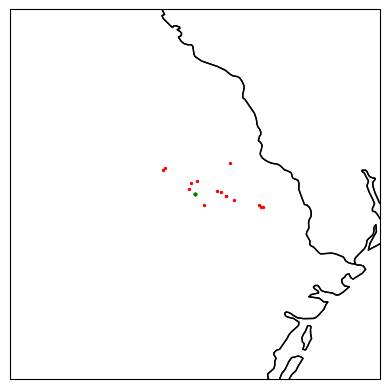

In [156]:
distance=1
hours=.5
filtered_data = filter_reports(wind_reports, event_1, distance, hours)
plot_storm_reports(center_event=event_1, events=filtered_data, distance=1)

2023-06-14 22:59:00 3


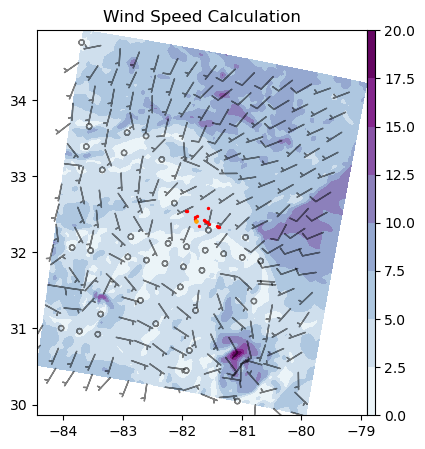

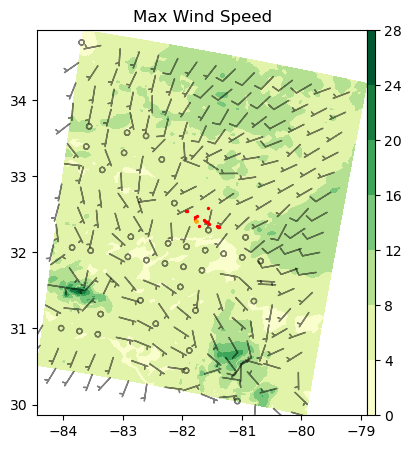

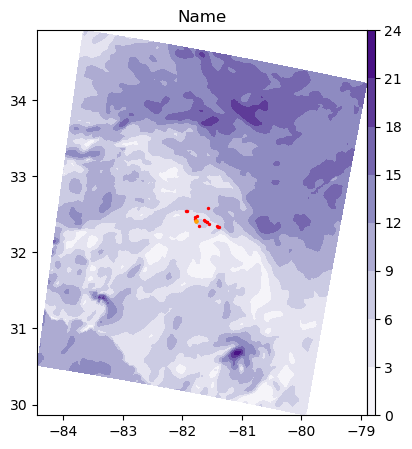

In [151]:
plot_interesting_events(event_1, filtered_data, 3, 1, .5)

2023-06-14 22:59:00 6


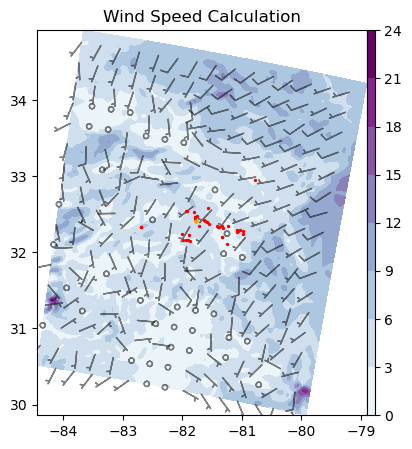

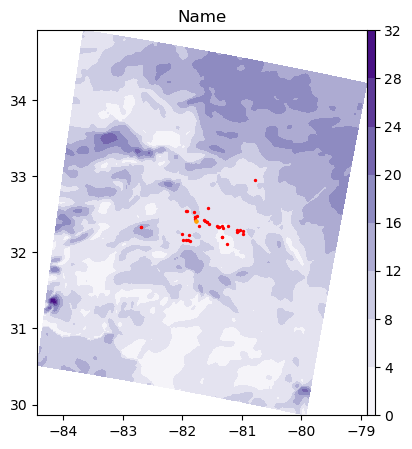

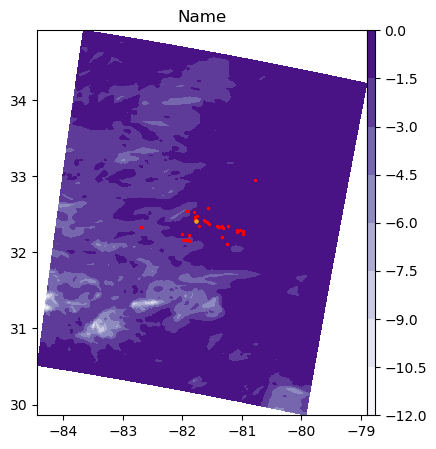

In [153]:
plot_interesting_events(event_1, filtered_data, 6, 1, 1)

2023-06-14 22:59:00 9


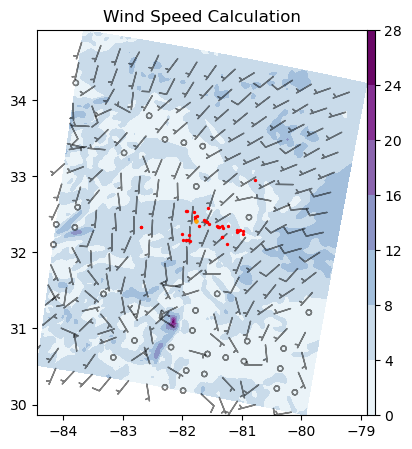

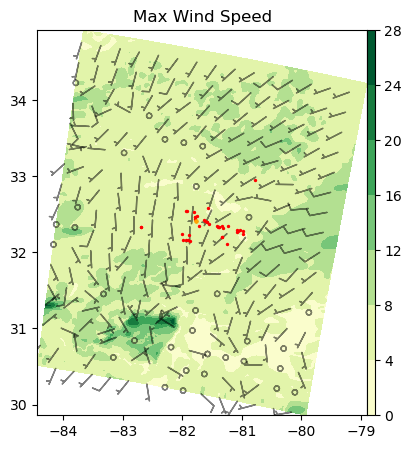

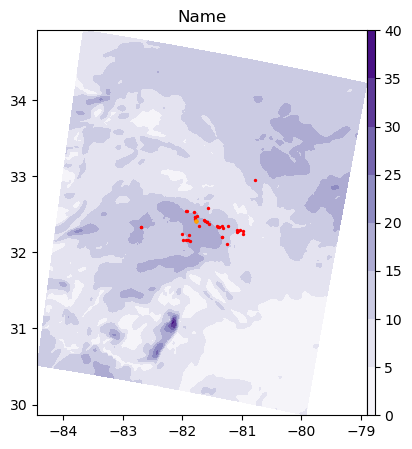

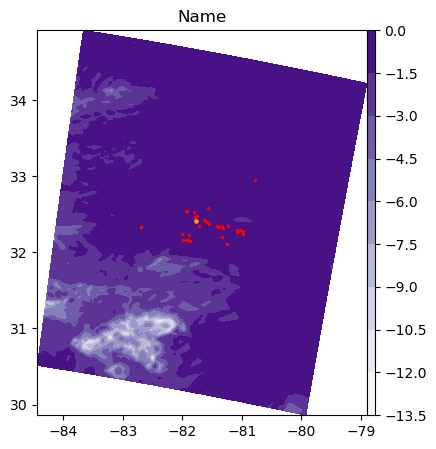

In [154]:
plot_interesting_events(event_1, filtered_data, 9, 1, 1)

## Interesting Report 2 ##

In [105]:
event_2 = wind_reports.loc[250]
event_2

Speed                                                     UNK
Location                                             Hartford
County                                                 Geneva
State                                                      AL
Lat                                                      31.1
Lon                                                     -85.7
Comments    Trees and powerlines reported down across Gene...
datetime                                  2023-06-14 23:54:00
Name: 250, dtype: object

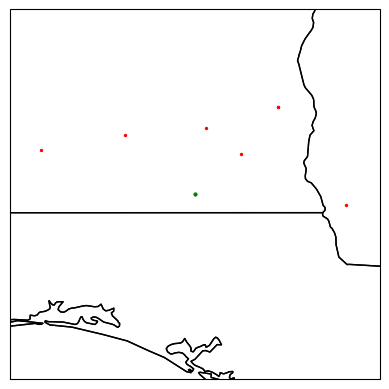

In [124]:
distance=1
hours=.5
filtered_data_2 = filter_reports(wind_reports, event_2, distance, hours)
plot_storm_reports(center_event=event_2, events=filtered_data_2, distance=1)

2023-06-14 23:54:00 3


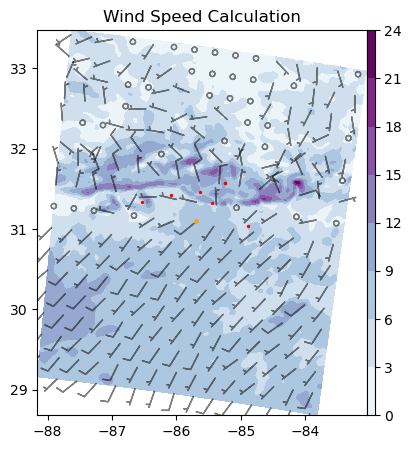

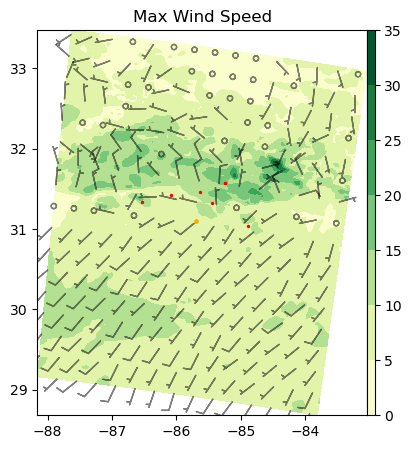

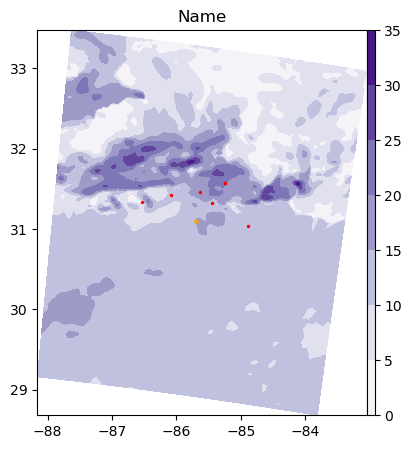

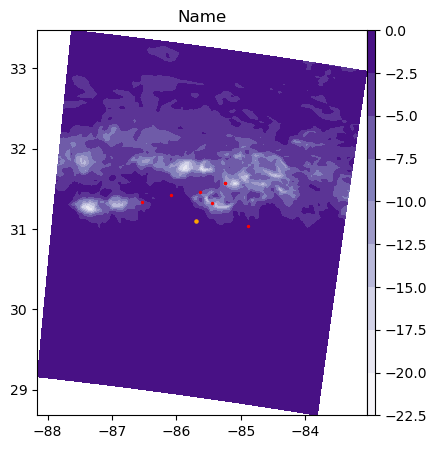

In [155]:
plot_interesting_events(event_2, filtered_data_2, forecast_hour=3, distance=1,time=.5)

2023-06-14 23:54:00 6


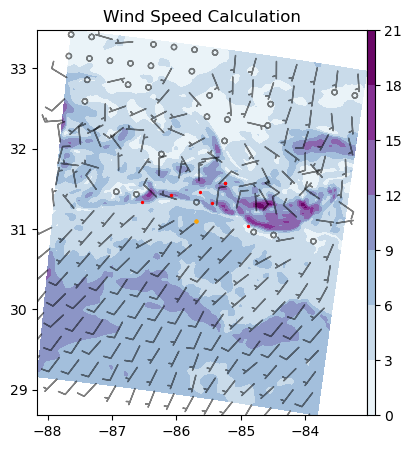

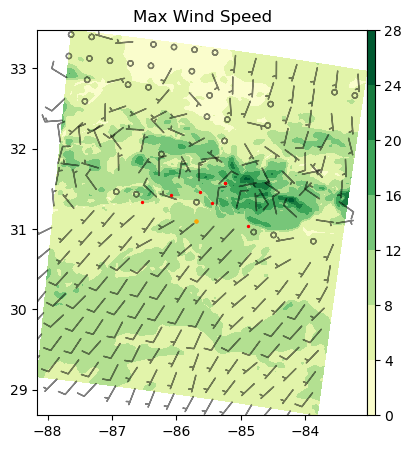

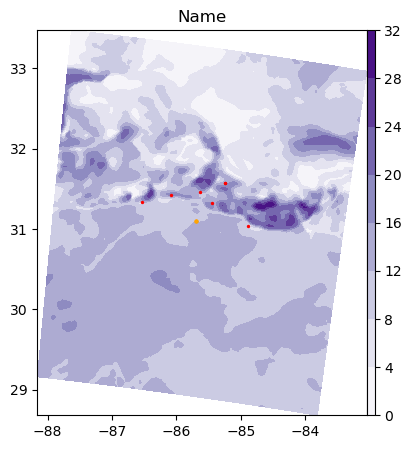

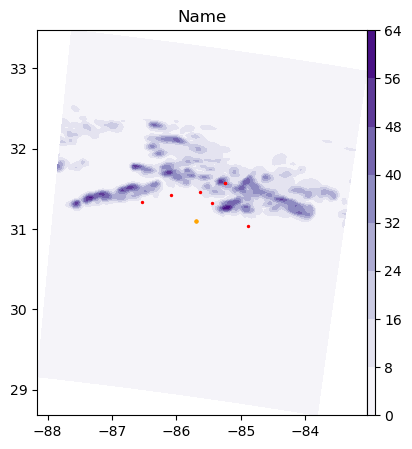

In [141]:
plot_interesting_events(event_2, filtered_data_2, forecast_hour=6, distance=1,time=.5)

2023-06-14 23:54:00 9


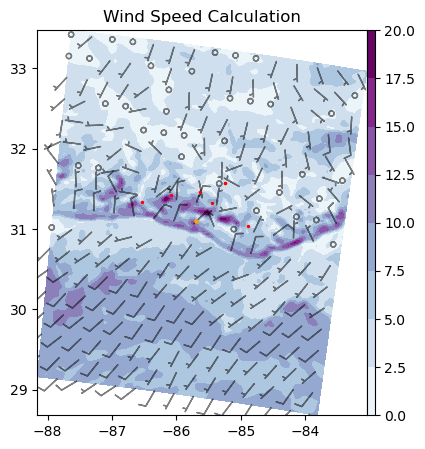

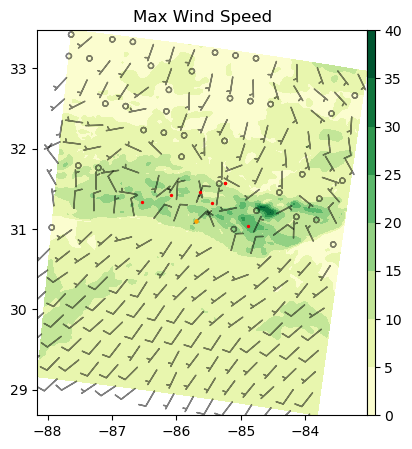

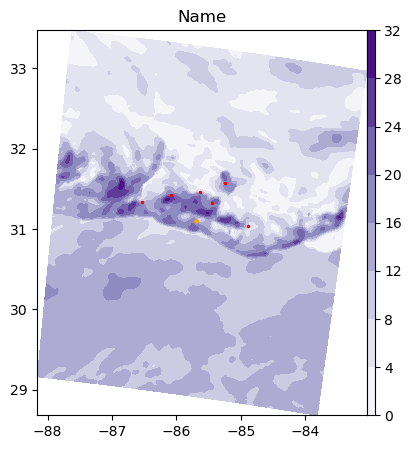

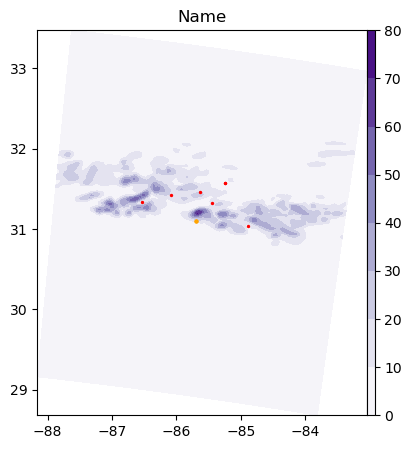

In [142]:
plot_interesting_events(event_2, filtered_data_2, forecast_hour=9, distance=1,time=.5)

## Interesting Report 3 ##

In [110]:
sc_report = wind_reports.loc[270]
sc_report

Speed                                                     UNK
Location                                         2 W Bluffton
County                                               Beaufort
State                                                      SC
Lat                                                     32.24
Lon                                                    -80.89
Comments    Report of a tree down near May River Rd and Li...
datetime                                  2023-06-15 00:10:00
Name: 270, dtype: object

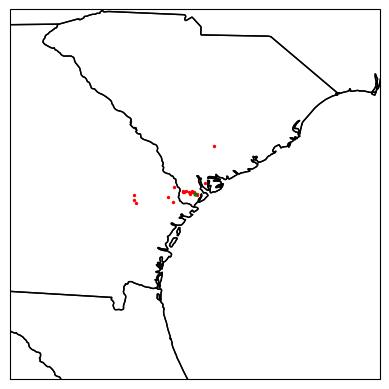

In [146]:
distance = 1
time = .5
sc_filtered_reports = filter_reports(wind_reports, sc_report, distance, time)
plot_storm_reports(sc_filtered_reports, sc_report, 3)

2023-06-15 00:10:00 3


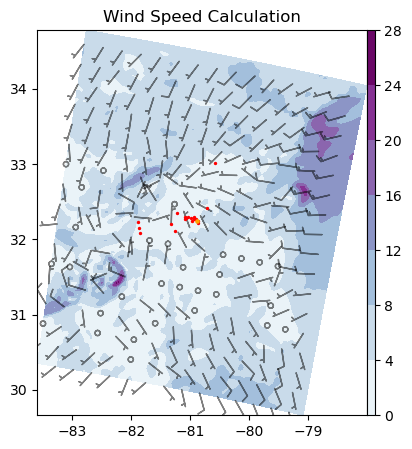

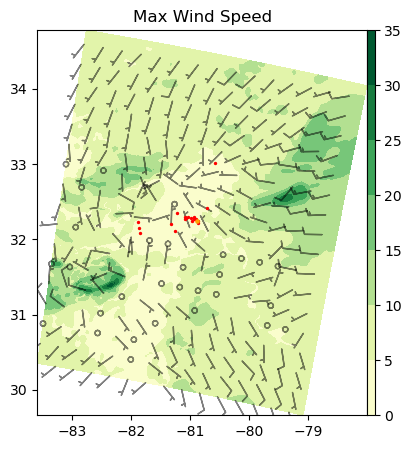

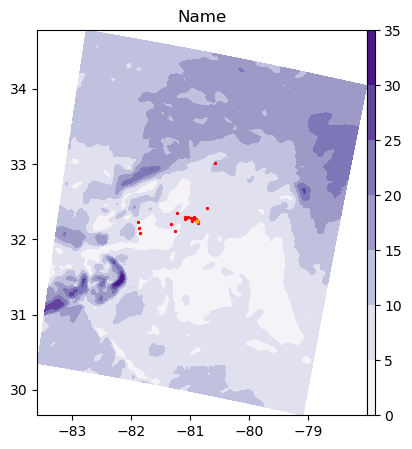

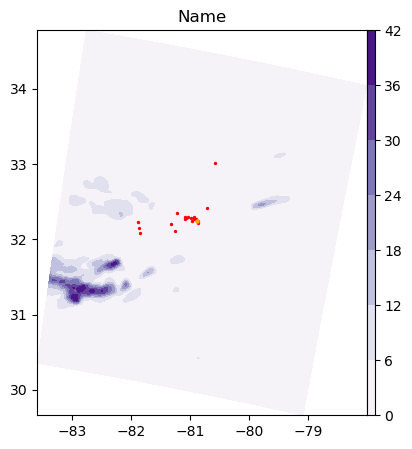

In [147]:
plot_interesting_events(sc_report, sc_filtered_reports, forecast_hour=3, distance=1,time=.5)

2023-06-15 00:10:00 6


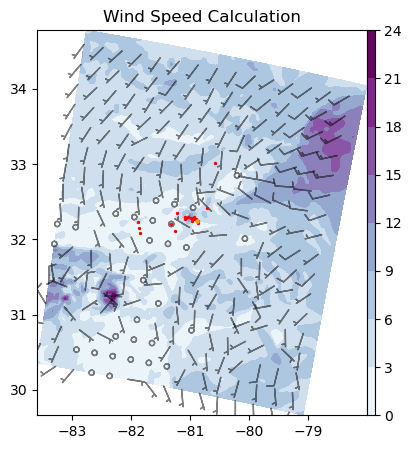

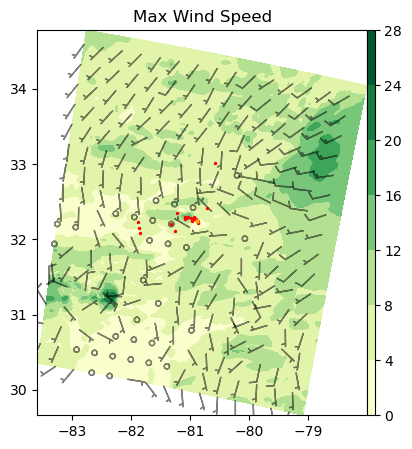

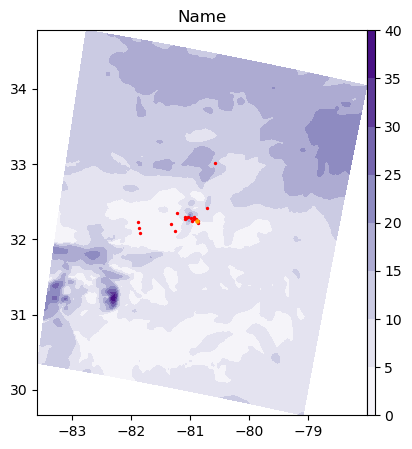

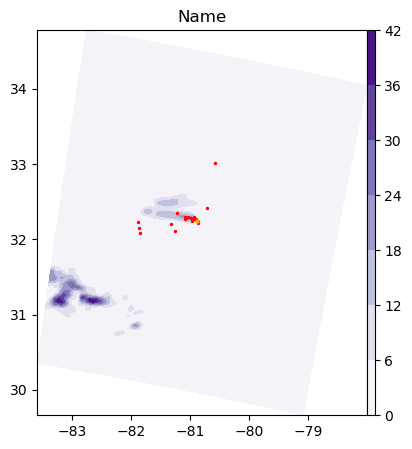

In [148]:
plot_interesting_events(sc_report, sc_filtered_reports, forecast_hour=6, distance=1,time=.5)

2023-06-15 00:10:00 9


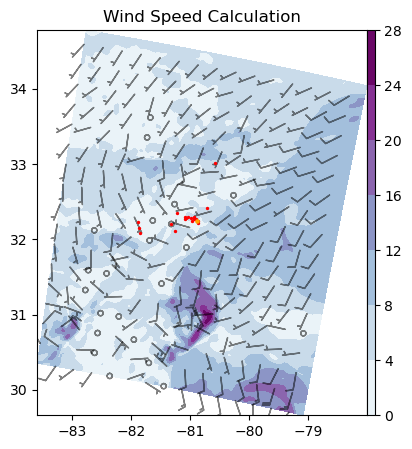

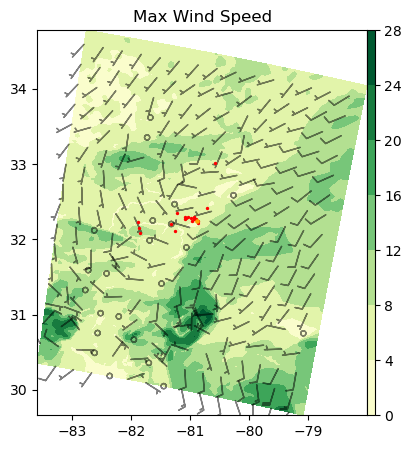

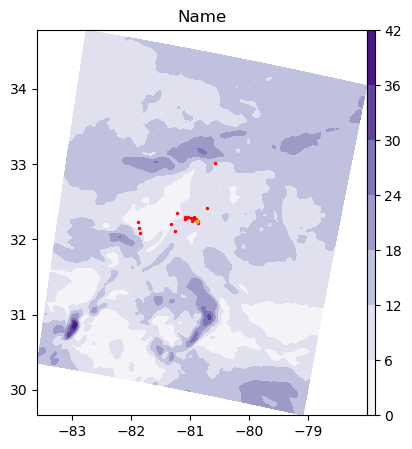

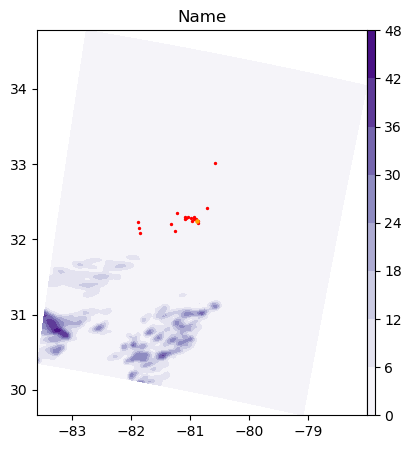

In [149]:
plot_interesting_events(sc_report, sc_filtered_reports, forecast_hour=9, distance=1,time=.5)

## 1.1 Texas Storm ##

In [65]:
tx_report = wind_reports.loc[32]
tx_report

Speed                                                     UNK
Location                                  5 ESE Phil Campbell
County                                               Franklin
State                                                      AL
Lat                                                     34.32
Lon                                                    -87.63
Comments    Trees and power lines were blown down along Ja...
datetime                                  2023-06-14 15:29:00
Name: 32, dtype: object

In [67]:
tx_filtered_reports = filter_reports(wind_reports, tx_report, 1, 1.5)
tx_filtered_reports

Speed             Location    County State    Lat    Lon  \
26   UNK        2 SSE Red Bay  Franklin    AL  34.40 -88.12   
32   UNK  5 ESE Phil Campbell  Franklin    AL  34.32 -87.63   
33   UNK         6 ENE Hodges  Franklin    AL  34.35 -87.83   

                                             Comments            datetime  
26  Trees and power lines were blown down along Hw... 2023-06-14 14:51:00  
32  Trees and power lines were blown down along Ja... 2023-06-14 15:29:00  
33  Trees and power lines were blown down at the i... 2023-06-14 15:29:00

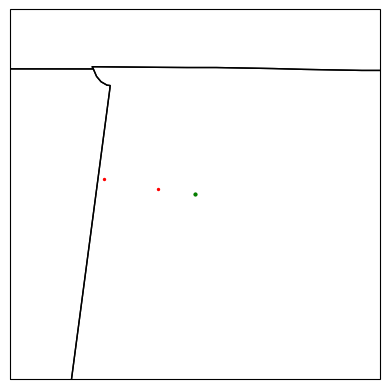

In [68]:
distance=1
hours=1.5
filtered_data_2 = filter_reports(wind_reports, tx_report, distance, hours)
plot_storm_reports(center_event=tx_report, events=tx_filtered_reports, distance=1)

1 Hour Forecast

2023-06-14 17:50:00 1


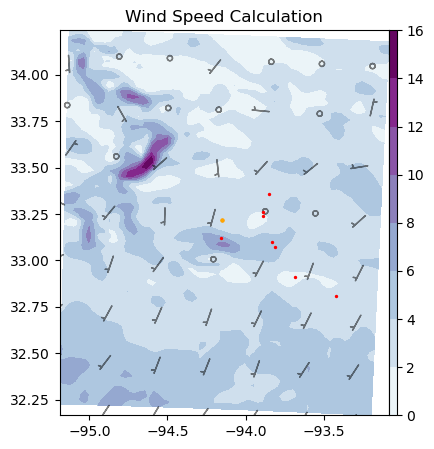

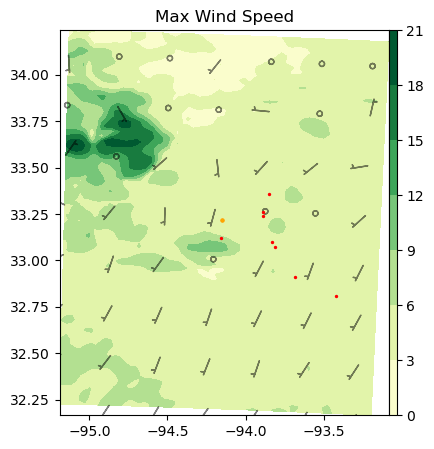

In [70]:
#1 Hour forecast
plot_interesting_events(tx_report, tx_filtered_reports, 1, 1)
# ds = fetch_rrfs_forecast(tx_report, 1)
# ds

3 Hour Forecast

2023-06-14 17:50:00 3


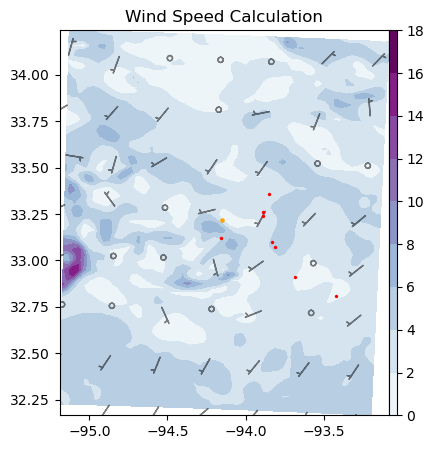

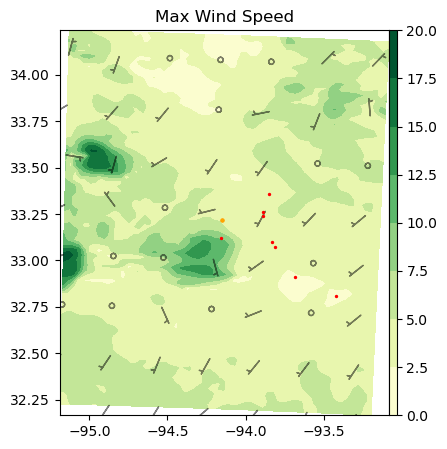

In [90]:
plot_interesting_events(tx_report, tx_filtered_reports, 3, 1)

6 Hours Forecast

2023-06-14 17:50:00 6
File succesfully downloaded


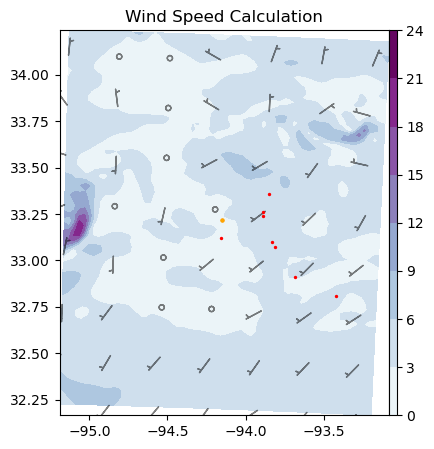

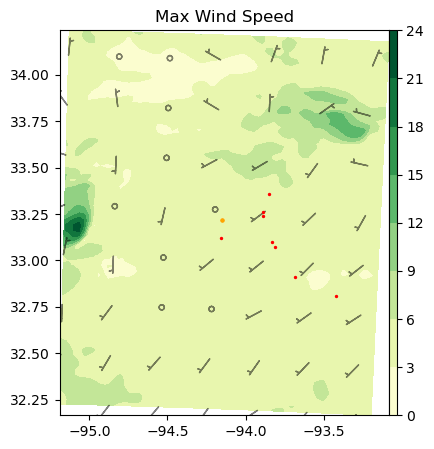

In [60]:
plot_interesting_events(tx_report, tx_filtered_reports, 6, 1)

9 Hour forecast

2023-06-14 17:50:00 9
File succesfully downloaded


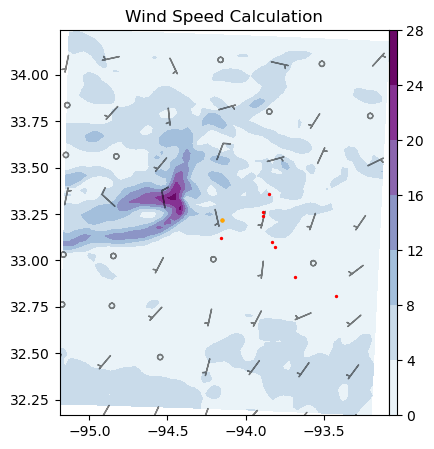

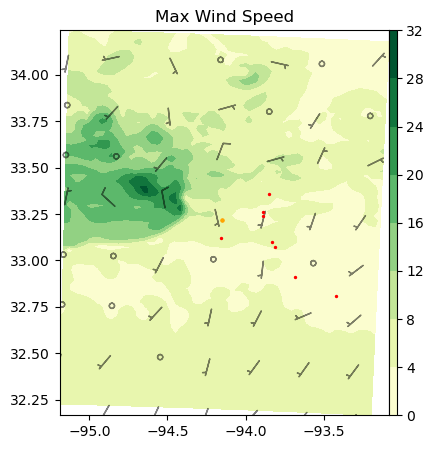

In [61]:
plot_interesting_events(tx_report, tx_filtered_reports, 9, 1)

## 1.3 GA Storm ##

In [45]:
ga_report = wind_reports.loc[26]
ga_report

Speed                                                  UNK
Location                                       3 SW Helena
County                                             Telfair
State                                                   GA
Lat                                                  32.04
Lon                                                 -82.96
Comments    Tree down at HWY 280 and Ken White Road. (FFC)
datetime                               2023-06-14 15:16:00
Name: 26, dtype: object

In [88]:
ga_filtered_events = filter_events(wind_reports, ga_report, 1, 1.5)
ga_filtered_events

Speed     Location   County State    Lat    Lon  \
26   UNK  3 SW Helena  Telfair    GA  32.04 -82.96   

                                          Comments            datetime  
26  Tree down at HWY 280 and Ken White Road. (FFC) 2023-06-14 15:16:00

2023-06-14 15:16:00 3


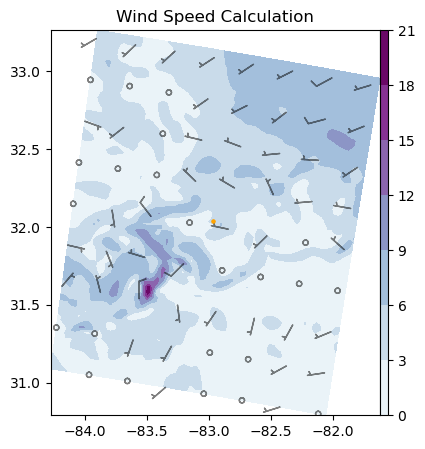

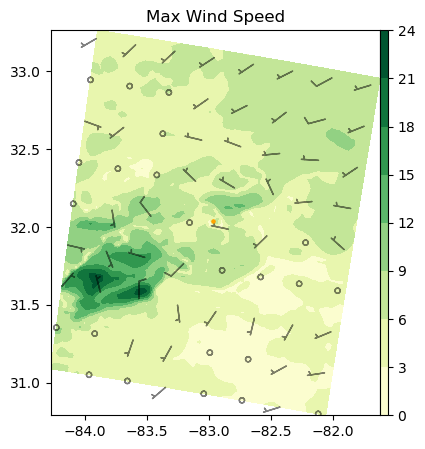

In [89]:
plot_interesting_events(ga_report, ga_filtered_events, 3, 1)

2023-06-14 15:16:00 6


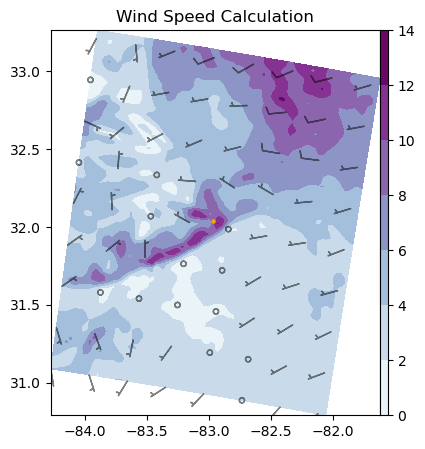

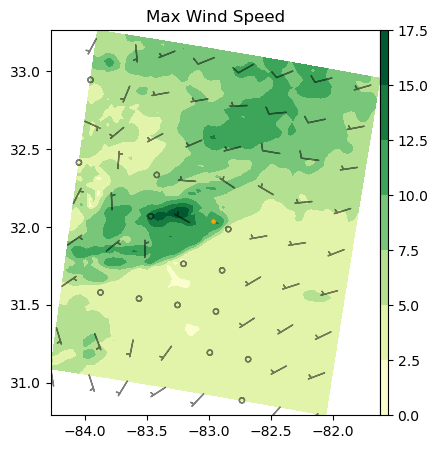

In [82]:
plot_interesting_events(ga_report, ga_filtered_events, 6, 1)

2023-06-14 15:16:00 9


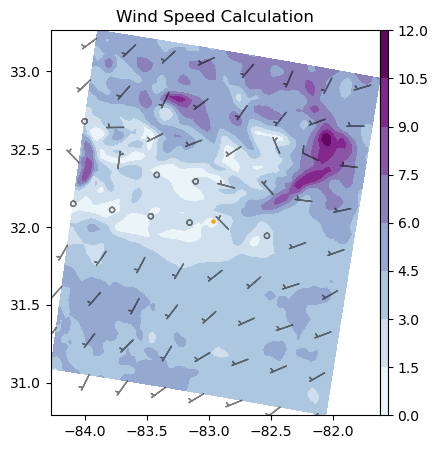

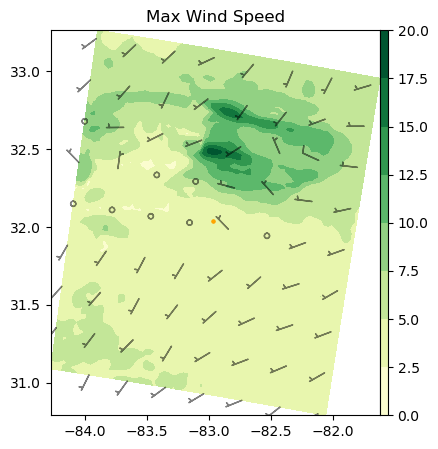

In [83]:
plot_interesting_events(ga_report, ga_filtered_events, 9, 1)

##  1.3 Alabama ##

In [44]:
al_report = wind_reports.loc[45]
al_report

Speed                                              UNK
Location                                    2 WSW Clay
County                                       Jefferson
State                                               AL
Lat                                              33.69
Lon                                             -86.63
Comments    Tree on a house on Dewey Heights Rd. (BMX)
datetime                           2023-06-14 18:45:00
Name: 45, dtype: object

In [75]:
al_filtered_events = filter_events(wind_reports, al_report, 1, 1.)
al_filtered_events

Speed                Location     County State    Lat    Lon  \
30   UNK  2 WNW Whitney Junction  St. Clair    AL  33.89 -86.33   
33   UNK               3 NE Lynn    Winston    AL  34.08 -87.51   
40   UNK          2 S Manchester     Walker    AL  33.87 -87.25   
42   UNK   2 NNE Village Springs     Blount    AL  33.79 -86.63   
43   UNK          2 N Smoke Rise     Blount    AL  33.91 -86.83   
44   UNK        2 NNE Smoke Rise     Blount    AL  33.90 -86.81   
45   UNK        1 ENE Smoke Rise     Blount    AL  33.89 -86.80   
46   UNK            1 NE Warrior  Jefferson    AL  33.83 -86.79   
47   UNK              2 WSW Clay  Jefferson    AL  33.69 -86.63   
49   UNK              1 ESE Argo  St. Clair    AL  33.69 -86.50   
51   UNK               Pell City  St. Clair    AL  33.59 -86.28   

                                             Comments            datetime  
30  Trees and power lines down on Crawford Cove Rd... 2023-06-14 17:45:00  
33                          Tree down on CR 25. (BMX) 2023-06-14 17:53:00  
40             Trees down on Walston Bridge Rd. (BMX) 2023-06-14 18:24:00  
42          Tree on vehicle on Red Valley Lane. (BMX) 2023-06-14 18:28:00  
43                     Trees down along HWY 31. (BMX) 2023-06-14 18:29:00  
44                RV overturned on Hallmark Rd. (BMX) 2023-06-14 18:30:00  
45  Trees and powerlines down on Rock Springs Rd. ... 2023-06-14 18:31:00  
46           Trees down on Warrior Trafford Rd. (BMX) 2023-06-14 18:36:00  
47         Tree on a house on Dewey Heights Rd. (BMX) 2023-06-14 18:45:00  
49    Tree blocking road on Briar Ridge Circle. (BMX) 2023-06-14 18:58:00  
51     Trees down across roadways in Pell City. (BMX) 2023-06-14 19:11:00

2023-06-14 18:45:00 1


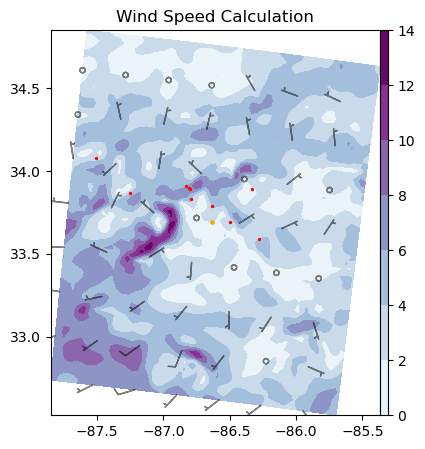

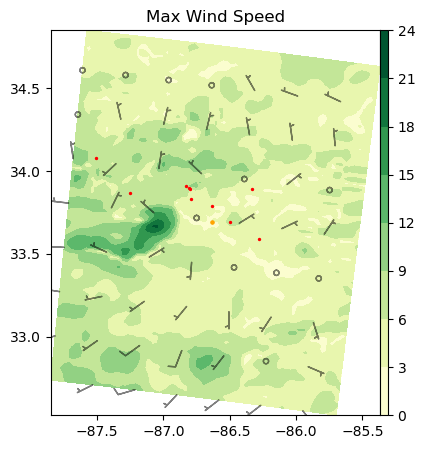

In [76]:
plot_interesting_events(al_report, al_filtered_events, 1, 1)

2023-06-14 18:45:00 3


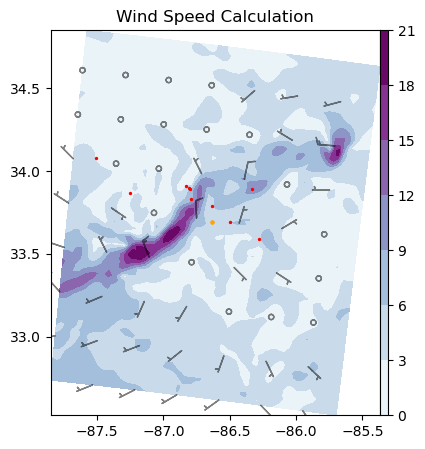

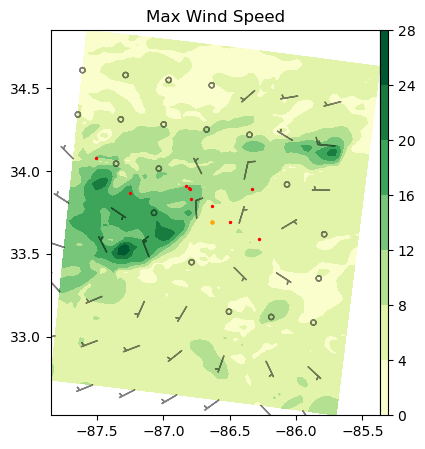

In [78]:
plot_interesting_events(al_report, al_filtered_events, 3, 1)

2023-06-14 18:45:00 6


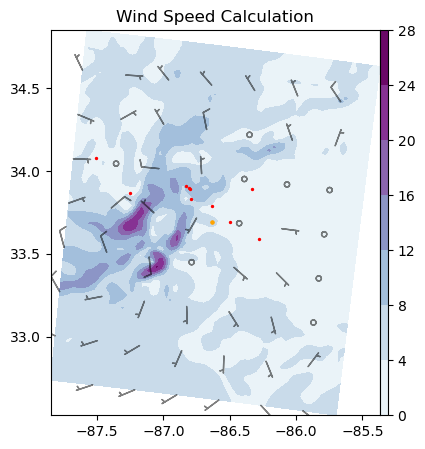

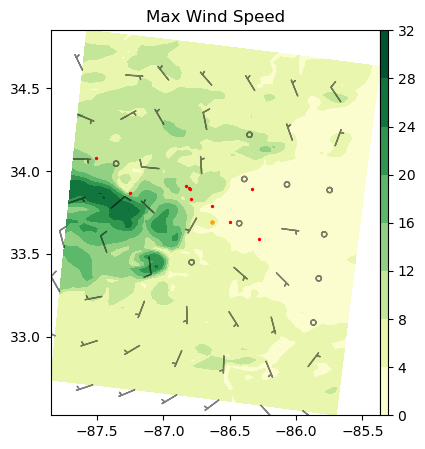

In [79]:
plot_interesting_events(al_report, al_filtered_events, 6, 1)

2023-06-14 18:45:00 9


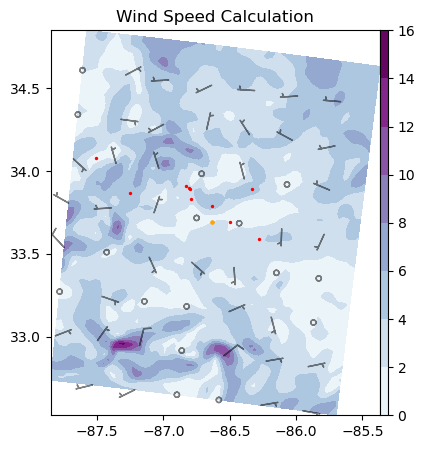

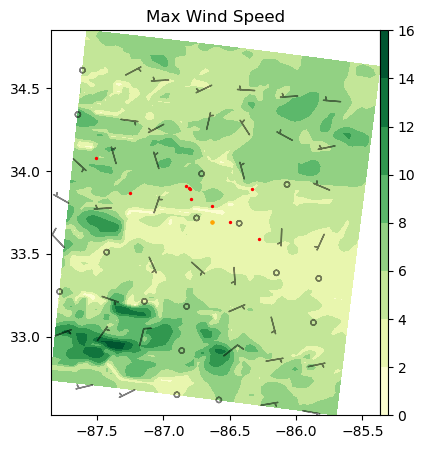

In [80]:
plot_interesting_events(al_report, al_filtered_events, 9, 1)

In [19]:
import matplotlib.pyplot as plt
import metpy.calc as mpcalc

def plot_max_wind_speed(ds, interesting_events, center_event, offset=3):

    # Calculate the total deformation of the flow
    wind_speed = mpcalc.wind_speed(ds.MAXUW_P8_L103_GLC0_max1h, ds.MAXVW_P8_L103_GLC0_max1h)
    # start figure and set axis
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # plot wind speed
    cf = ax.contourf(ds.coords['gridlon_0'], 
                     ds.coords['gridlat_0'], 
                     wind_speed, cmap=plt.cm.BuPu)
    plt.colorbar(cf, pad=0, aspect=50)
    ax.barbs(ds.coords['gridlon_0'][0::offset, 0::offset],
             ds.coords['gridlat_0'][0::offset, 0::offset],
             ds.UGRD_P0_L103_GLC0[0::offset, 0::offset], 
             ds.VGRD_P0_L103_GLC0[0::offset, 0::offset], 
             color='black', length=5, alpha=0.5)
   
    ax.set_title('Wind Speed Calculation')
    
    plt.scatter(
            x = interesting_events["Lon"],
            y = interesting_events["Lat"],
            color="red",
            s=2,
            alpha=1
        )
    
    plt.scatter(
        x=center_event["Lon"],
        y=center_event["Lat"],
        color="Orange",
        s=5
    )
    plt.show()



2023-06-14 18:15:00 3


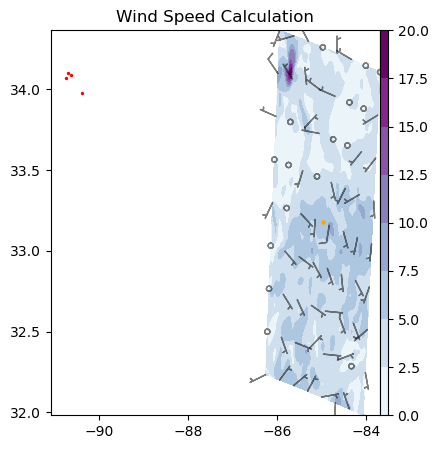

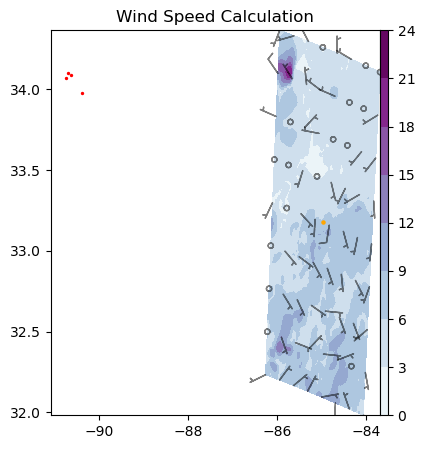

In [57]:
ga_report_2 = wind_reports.loc[34]
ga_filtered_events_2 = filter_events(wind_reports, ga_report, 1, 1.5)
plot_interesting_events(ga_report_2, ga_filtered_events_2, 3)

2023-06-14 14:26:00 6
File succesfully downloaded


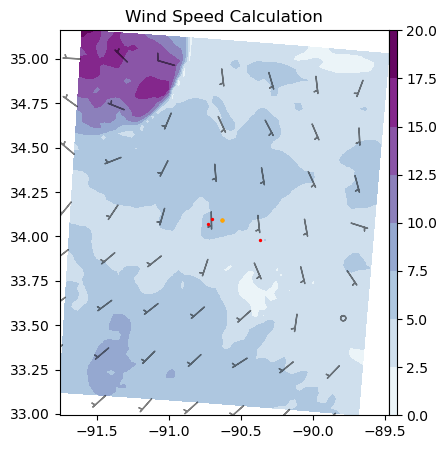

In [55]:
ga_report = wind_reports.loc[24]
ga_filtered_events = filter_events(wind_reports, ga_report)
plot_interesting_events(ga_report, ga_filtered_events, 6)

2023-06-14 14:26:00 9
File succesfully downloaded


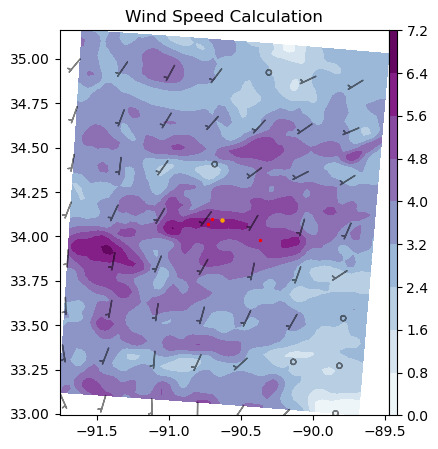

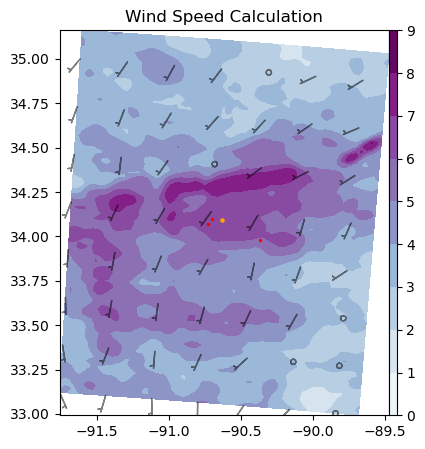

In [56]:
ga_report = wind_reports.loc[24]
ga_filtered_events = filter_events(wind_reports, ga_report)
plot_interesting_events(ga_report, ga_filtered_events, 9)

In [81]:
ds = fetch_rrfs_forecast(event_1, 3)

2023-06-14 22:59:00 3


In [82]:
ds.

<xarray.Dataset>
Dimensions:                          (ygrid_0: 1059, xgrid_0: 1799,
                                      lv_ISBL0: 5, lv_AMSL1: 10, lv_HYBL2: 65,
                                      lv_SPDL3: 6, lv_ISBL4: 4, lv_HTGL5: 2,
                                      lv_SIGL6: 22, lv_SPDL7: 3, lv_HTGL8: 2,
                                      lv_DBLL9: 9, lv_HTGL10: 2, lv_HTGL11: 2,
                                      lv_HTGL12: 2)
Coordinates:
  * lv_HTGL12                        (lv_HTGL12) float32 1.0 2.0
  * lv_SIGL6                         (lv_SIGL6) float32 0.053 0.158 ... 0.9975
  * lv_HTGL5                         (lv_HTGL5) float32 2.0 10.0
  * lv_ISBL4                         (lv_ISBL4) float32 2.5e+04 ... 8.5e+04
  * lv_HYBL2                         (lv_HYBL2) float32 1.0 2.0 ... 64.0 65.0
  * lv_AMSL1                         (lv_AMSL1) float32 305.0 ... 4.572e+03
  * lv_ISBL0                         (lv_ISBL0) float32 2.5e+04 ... 9.5e+04
    gridlat_0                        (ygrid_0, xgrid_0) float32 ...
    gridlon_0                        (ygrid_0, xgrid_0) float32 ...
Dimensions without coordinates: ygrid_0, xgrid_0, lv_SPDL3, lv_SPDL7, lv_HTGL8,
                                lv_DBLL9, lv_HTGL10, lv_HTGL11
Data variables: (12/217)
    TMP_P0_L1_GLC0                   (ygrid_0, xgrid_0) float32 ...
    TMP_P0_L3_GLC0                   (ygrid_0, xgrid_0) float32 ...
    TMP_P0_L7_GLC0                   (ygrid_0, xgrid_0) float32 ...
    TMP_P0_L100_GLC0                 (lv_ISBL0, ygrid_0, xgrid_0) float32 ...
    TMP_P0_L102_GLC0                 (lv_AMSL1, ygrid_0, xgrid_0) float32 ...
    TMP_P0_L103_GLC0                 (ygrid_0, xgrid_0) float32 ...
    ...                               ...
    lv_HTGL8_l0                      (lv_HTGL8) float32 ...
    lv_SPDL7_l1                      (lv_SPDL7) float32 ...
    lv_SPDL7_l0                      (lv_SPDL7) float32 ...
    lv_SPDL3_l1                      (lv_SPDL3) float32 ...
    lv_SPDL3_l0                      (lv_SPDL3) float32 ...
    gridrot_0                        (ygrid_0, xgrid_0) float32 ...

In [91]:
def plot_gust_potential(ds, interesting_events, center_event, offset=3):
    #Plots the max wind speed variable
    # Calculate the total deformation of the flow
    # wind_speed = mpcalc.wind_speed(ds.MAXUW_P8_L103_GLC0_max1h, ds.MAXVW_P8_L103_GLC0_max1h)
    # start figure and set axis
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # plot wind speed
    cf = ax.contourf(ds.coords['gridlon_0'], 
                     ds.coords['gridlat_0'], 
                     ds.GUST_P0_L1_GLC0, cmap=plt.cm.YlGn)
    plt.colorbar(cf, pad=0, aspect=50)
    ax.set_title('Gust Potential')
    
    plt.scatter(
            x = interesting_events["Lon"],
            y = interesting_events["Lat"],
            color="red",
            s=2,
            alpha=1
        )
    
    plt.scatter(
        x=center_event["Lon"],
        y=center_event["Lat"],
        color="Orange",
        s=5
    )
    plt.show()
    

## June 15 ##

In [160]:
june_15_reports = get_wind_report(pd.Timestamp(year=2023, month=6, day=15))

In [174]:
interesting_events(june_15_reports)

1 2
2 2
3 3
4 4
5 2
6 2
7 4
8 6
9 4
10 6
11 3
12 4
13 3
14 7
15 7
16 7
17 7
18 2
19 8
20 8
21 3
22 2
23 8
24 7
25 6
26 1
27 8
28 17
29 10
30 16
31 14
32 14
33 16
34 14
35 14
36 7
37 15
38 5
39 13
40 7
41 14
42 4
43 13
44 4
45 13
46 13
47 14
48 13
49 13
50 13
51 5
52 13
53 16
54 13
55 13
56 12
57 16
58 20
59 18
60 27
61 24
62 26
63 27
64 27
65 27
66 27
67 4
68 25
69 25
70 5
71 16
72 5
73 16
74 27
75 2
76 5
77 16
78 16
79 2
80 16
81 16
82 5
83 18
84 18
85 9
86 27
87 27
88 18
89 27
90 18
91 14
92 12
93 13
94 13
95 27
96 8
97 33
98 31
99 11
100 27
101 31
102 31
103 30
104 28
105 1
106 2
107 26
108 26
109 5
110 25
111 5
112 5
113 25
114 5
115 12
116 26
117 8
118 10
119 12
120 11
121 10
122 10
123 3
124 10
125 3
126 3
127 1
128 13
129 13
130 21
131 8
132 10
133 6
134 14
135 13
136 12
137 13
138 14
139 17
140 12
141 11
142 7
143 12
144 3
145 9
146 14
147 16
148 11
149 16
150 1
151 19
152 9
153 18
154 18
155 1
156 16
157 18
158 19
159 7
160 6
161 11
162 17
163 3
164 18
165 2
166 18
167 17
168 

[Speed                             UNK
 Location             2 SW Williamston
 County                       Anderson
 State                              SC
 Lat                              34.6
 Lon                             -82.5
 Comments    Several trees down. (GSP)
 datetime          2023-06-15 22:02:00
 Name: 59, dtype: object,
 Speed                                                     UNK
 Location                                    4 WNW Harbor View
 County                                                  Lucas
 State                                                      OH
 Lat                                                     41.72
 Lon                                                    -83.52
 Comments    Multiple utility poles down and report of a ro...
 datetime                                  2023-06-15 22:07:00
 Name: 60, dtype: object,
 Speed                                                     UNK
 Location                                    3 WNW Harbor View
 Count

In [161]:
june_15_reports[june_15_reports["Lat"] == 33.03]

Speed Location  County State    Lat    Lon  \
169   UNK    Lavon  Collin    TX  33.03 -96.44   
170    78    Lavon  Collin    TX  33.03 -96.44   

                                              Comments            datetime  
169  Several trees down and structural damage repor... 2023-06-16 03:50:00  
170     EM reports 78mph gust measured in Lavon. (FWD) 2023-06-16 03:52:00

In [185]:
event = june_15_reports.loc[278]
event

Speed                                          UNK
Location                              1 ENE Cleary
County                                      Rankin
State                                           MS
Lat                                          32.17
Lon                                         -90.17
Comments    Tree downed on Cleary Church Rd. (JAN)
datetime                       2023-06-16 10:18:00
Name: 278, dtype: object

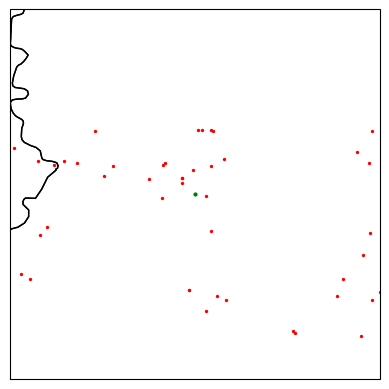

In [186]:
distance=1
hours=1.5
filtered_data = filter_reports(june_15_reports, event, distance, hours)
plot_storm_reports(center_event=event, events=filtered_data, distance=1)

2023-06-16 10:18:00 3
File succesfully downloaded


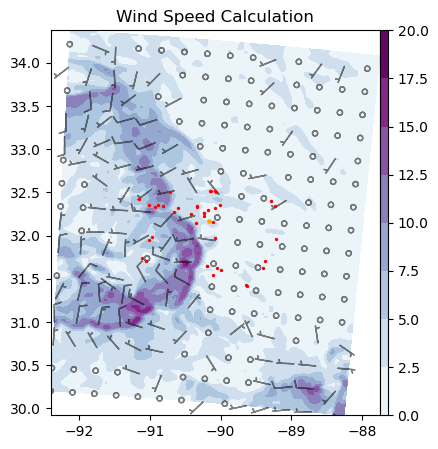

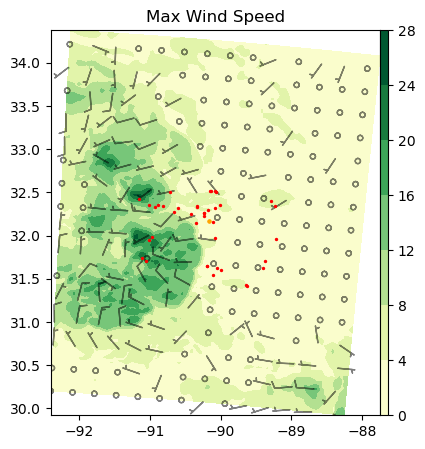

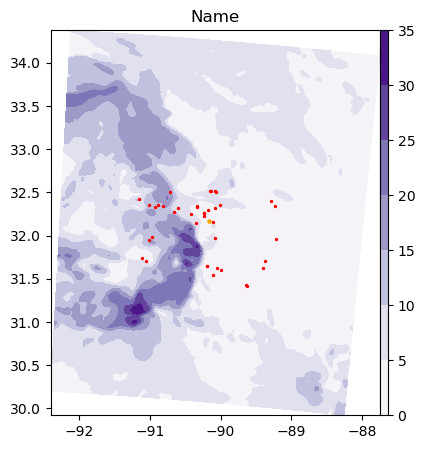

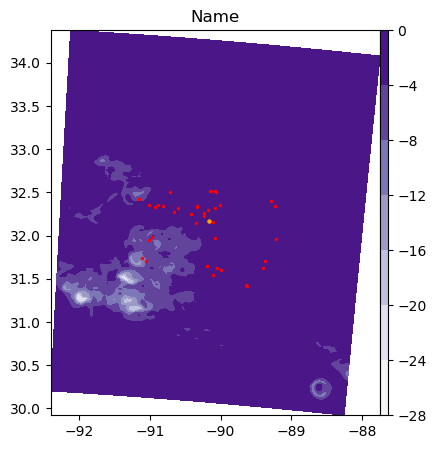

In [187]:
plot_interesting_events(event, filtered_data, 3, 1, 1)

In [ ]:
plot_interesting_events(event, filtered_data, , 1, 1)


In [190]:
class spatial_slice:
    def __init__(self, df, center, bounding_box):
        self.df = df
        self.center = center
        self.bounding_box = bounding_box

    def plot_slice(self):

        # figure = plt.figure()
        
        # ax = figure.subplots(1,1,1,projection=ccrs.PlateCarree())
        # ax = plt.axes(projection=ccrs.LambertConformal())
        # ax.add_feature(cfeature.COASTLINE)
        # ax.add_feature(cfeature.STATES)
        figure = plt.figure()
    
        ax = figure.add_subplot(1,1,1,projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.STATES)
        ax.set_extent(
            [self.center["Lon"] - 2, 
             self.center["Lon"] + 2, 
             self.center["Lat"] - 2, 
            self.center["Lat"] + 2],
            crs=ccrs.PlateCarree()
        )
        # ax.scatter(
        #     x = self.df["Lon"],
        #     y = self.df["Lat"],
        #     color="red",
        #     s=2,
        #     alpha=1,
        #     transform=ccrs.PlateCarree()
        # )
        
        
        # if center_event:
        # ax.scatter(
        #     x = self.center["Lon"],
        #     y = self.center["Lat"],
        #     color="green",
        #     s=4,
        #     alpha=1,
        #     transform=ccrs.PlateCarree()
        # )
        # print(self.bounding_box.is_closed)
        x,y = self.bounding_box.exterior.xy
        # plt.plot(x,y)
        # print(x,y)
        # ax.gridlines()
        # print(self.bounding_box)
        # ax.add_geometries([self.bounding_box], crs=ccrs.PlateCarree(), facecolor='red', edgecolor='k')
        ax.plot(x,y, transform=ccrs.PlateCarree())
        # plt.show()
        return 

In [96]:


#Adds time bins column to daily reports
def add_time_bins(daily_reports, day_datetime, bin_size=3):
    
    hourly_bins = make_time_bins(day_datetime, bin_size)
    bins = []
    
    for row in daily_reports.iterrows():
        # print(row[1])
        bins.append(get_bin(row[1], hourly_bins, bin_size))
    daily_reports["bins"] = bins

    return daily_reports

#Gets the correct bin for a given row 
def get_bin(report, hourly_bins, bin_size):
    time = report["datetime"]
    for bin in hourly_bins:
        if time.hour - bin.hour < bin_size:
            return bin
    return 

def make_time_bins(day_datetime, bin_size):
    start = pd.Timestamp(year=day_datetime.year, month=day_datetime.month, day=day_datetime.day, hour=0)
    end = pd.Timestamp(year=day_datetime.year, month=day_datetime.month, day=day_datetime.day, hour=23)
    return pd.date_range(start, end, freq=f'{bin_size}H')
    # return 

def get_bounding_box(center_event, size):
    lat = center_event["Lat"]
    lon = center_event["Lon"]
    b = shapely.box(lat - size, lon - size, lat + size, lon + size)
    return b

def get_slices(df):
    slices = []
    while df.size > 0:
        entry = df.loc[0]
        data = spatial_filter(df, entry["Lat"], entry["Lon"], distance=1)
        bounding_box = get_bounding_box(entry, 0.5)
        slice = spatial_slice(data, entry, bounding_box)
        slices.append(slice)
        df = df[~df.index.isin(slice.df.index)]
        df = df.reset_index(drop=True)
        
        # print(len(slices))
    return slices


In [35]:
day = pd.Timestamp(year = 2023, month=6, day=21)
daily_reports = get_wind_report(day)
hourly_bins = make_time_bins(day, 3)
daily_reports

Speed                 Location     County State    Lat     Lon  \
0     UNK  1 SSE Macon Community P       Leon    FL  30.48  -84.28   
1     UNK     Macon Community Park       Leon    FL  30.48  -84.28   
2     UNK              2 N Chaires       Leon    FL  30.47  -84.13   
3     UNK              3 SW Mayday     Echols    GA  30.80  -83.05   
4     UNK                 7 N Bell  Gilchrist    FL  29.86  -82.87   
..    ...                      ...        ...   ...    ...     ...   
107    58            6 SSE Baldwin   Burleigh    ND  46.95 -100.68   
108   UNK         1 NE Adams Beach     Taylor    FL  29.89  -83.62   
109    58          3 SSW Eastpoint     GMZ755    FL  29.71  -84.89   
110    58  3 NNW Saint George Isla   Franklin    FL  29.70  -84.89   
111   UNK         1 NE Adams Beach     Taylor    FL  29.89  -83.62   

                                              Comments            datetime  
0    Large tree down blocking Meridian Road at Wave... 2023-06-21 13:03:00  
1    Large tree down blocking Meridian Road at Sinc... 2023-06-21 13:11:00  
2    Tree down on Chaires Cross Road and Hill N Bar... 2023-06-21 14:14:00  
3    Delayed report: Two trees down on Highway 135N... 2023-06-21 14:25:00  
4    Delayed report from Emergency manager of large... 2023-06-21 16:05:00  
..                                                 ...                 ...  
107                    Personal weather station. (BIS) 2023-06-22 09:00:00  
108  EM says there are tree-down reports in Taylor ... 2023-06-22 09:05:00  
109  Weatherstem site at Saint George Island Bridge... 2023-06-22 09:33:00  
110  Saint George Island Bridge WeatherSTEM gusted ... 2023-06-22 09:34:00  
111  Corrects time of previous tstm wnd dmg report ... 2023-06-22 11:30:00  

[112 rows x 8 columns]

In [36]:
daily_reports = add_time_bins(daily_reports, day)
g_daily_reports = daily_reports.groupby(by=["bins"])
g_daily_reports.describe()

Lat                                                   \
                    count       mean    min      25%    50%     75%    max   
bins                                                                         
2023-06-21 00:00:00  39.0  33.798205  29.52  30.1700  30.96  34.160  45.99   
2023-06-21 03:00:00  38.0  34.367895  29.72  32.4525  32.48  32.825  46.88   
2023-06-21 06:00:00   3.0  44.363333  38.59  42.7600  46.93  47.250  47.57   
2023-06-21 09:00:00   5.0  33.228000  29.70  29.7100  29.89  29.890  46.95   
2023-06-21 12:00:00   4.0  30.557500  30.47  30.4775  30.48  30.560  30.80   
2023-06-21 15:00:00   5.0  29.798000  28.78  29.8600  29.95  30.120  30.28   
2023-06-21 18:00:00   3.0  35.206667  30.89  32.2450  33.60  37.365  41.13   
2023-06-21 21:00:00  15.0  30.972667  30.05  30.2800  31.46  31.495  32.09   

                                Lon              ...                     \
                          std count        mean  ...     max        std   
bins                                             ...                      
2023-06-21 00:00:00  5.235533  39.0  -98.538462  ...  -95.24   3.379342   
2023-06-21 03:00:00  4.879416  38.0 -100.067632  ...  -85.03   2.657201   
2023-06-21 06:00:00  5.010083   3.0 -102.266667  ... -100.91   1.335527   
2023-06-21 09:00:00  7.671390   5.0  -87.540000  ...  -83.62   7.372879   
2023-06-21 12:00:00  0.161735   4.0  -83.935000  ...  -83.05   0.594222   
2023-06-21 15:00:00  0.591456   5.0  -82.788000  ...  -82.55   0.152709   
2023-06-21 18:00:00  5.305698   3.0  -94.353333  ...  -80.31  12.266028   
2023-06-21 21:00:00  0.699750  15.0  -97.462667  ...  -96.06   1.409323   

                    datetime                                 \
                       count                           mean   
bins                                                          
2023-06-21 00:00:00       39  2023-06-22 01:39:38.461538048   
2023-06-21 03:00:00       38  2023-06-22 04:43:14.210526720   
2023-06-21 06:00:00        3            2023-06-22 07:20:40   
2023-06-21 09:00:00        5            2023-06-22 09:44:24   
2023-06-21 12:00:00        4            2023-06-21 13:43:15   
2023-06-21 15:00:00        5            2023-06-21 16:27:00   
2023-06-21 18:00:00        3            2023-06-21 19:54:20   
2023-06-21 21:00:00       15            2023-06-21 23:07:12   

                                                               \
                                     min                  25%   
bins                                                            
2023-06-21 00:00:00  2023-06-22 00:00:00  2023-06-22 00:48:30   
2023-06-21 03:00:00  2023-06-22 03:00:00  2023-06-22 04:14:00   
2023-06-21 06:00:00  2023-06-22 06:05:00  2023-06-22 06:46:00   
2023-06-21 09:00:00  2023-06-22 09:00:00  2023-06-22 09:05:00   
2023-06-21 12:00:00  2023-06-21 13:03:00  2023-06-21 13:09:00   
2023-06-21 15:00:00  2023-06-21 16:05:00  2023-06-21 16:05:00   
2023-06-21 18:00:00  2023-06-21 19:07:00  2023-06-21 19:24:00   
2023-06-21 21:00:00  2023-06-21 21:11:00  2023-06-21 22:52:30   

                                                               \
                                     50%                  75%   
bins                                                            
2023-06-21 00:00:00  2023-06-22 01:48:00  2023-06-22 02:15:00   
2023-06-21 03:00:00  2023-06-22 04:53:30  2023-06-22 05:15:00   
2023-06-21 06:00:00  2023-06-22 07:27:00  2023-06-22 07:58:30   
2023-06-21 09:00:00  2023-06-22 09:33:00  2023-06-22 09:34:00   
2023-06-21 12:00:00  2023-06-21 13:42:30  2023-06-21 14:16:45   
2023-06-21 15:00:00  2023-06-21 16:15:00  2023-06-21 16:20:00   
2023-06-21 18:00:00  2023-06-21 19:41:00  2023-06-21 20:18:00   
2023-06-21 21:00:00  2023-06-21 23:10:00  2023-06-21 23:39:30   

                                               
                                     max  std  
bins                                           
2023-06-21 00:00:00  2023-06-22 02:57:00  NaN  
2023-06-21 03:00:00

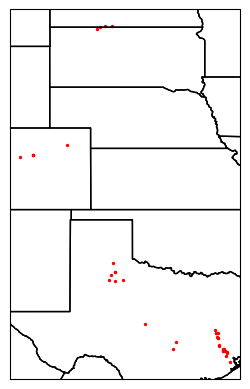

In [37]:
events = g_daily_reports.get_group(hourly_bins[0])
plot_storm_reports(events)

In [184]:
get_bounding_box(events.loc[0], 1).exterior.coords.xy

(array('d', [32.1, 32.1, 30.1, 30.1, 32.1]),
 array('d', [-96.97, -94.97, -94.97, -96.97, -96.97]))

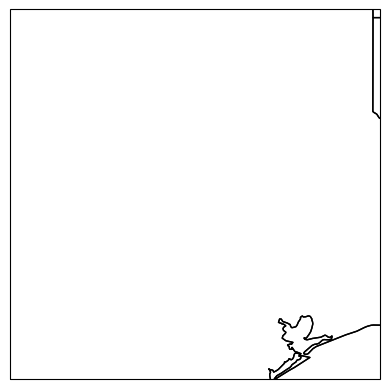

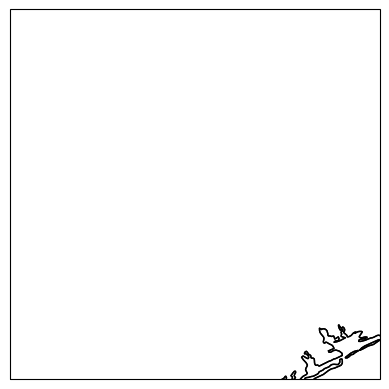

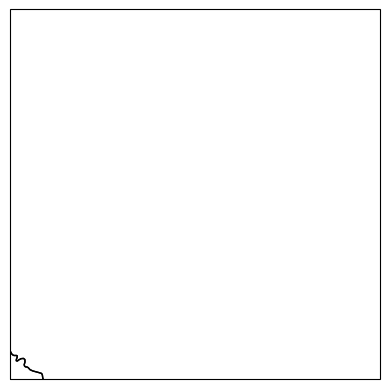

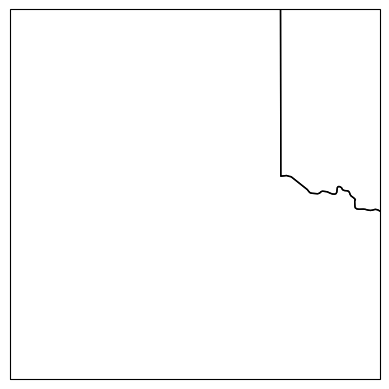

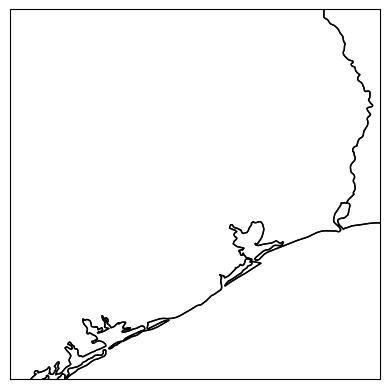

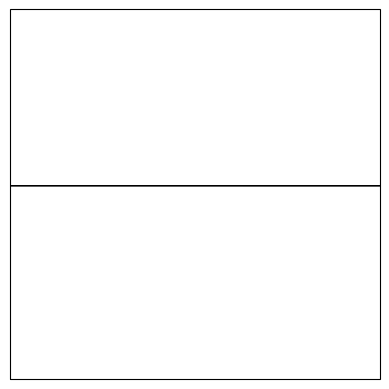

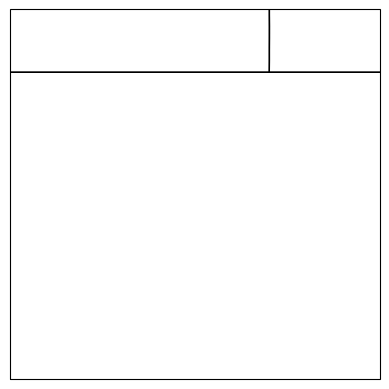

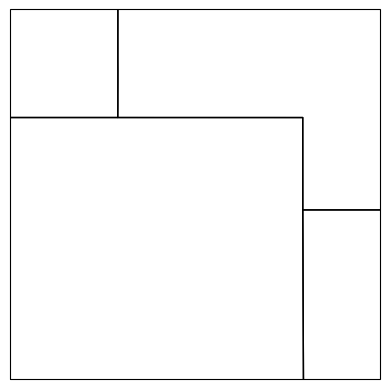

In [191]:
events = events.reset_index(drop=True)
slices = get_slices(events)
# print(slices)|
for slice in slices:
    slice.plot_slice()
    # plot_storm_reports(slice)

In [92]:
a = shapely.Polygon(slices[0].bounding_box)

In [345]:
# bin = g_reports.get_group(hourly_bins[0])
# plot_storm_reports(bin, distance=1)

shapely.geometry.polygon.Polygon

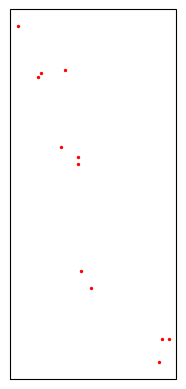

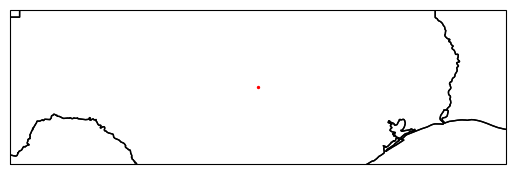

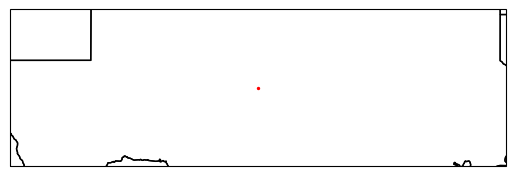

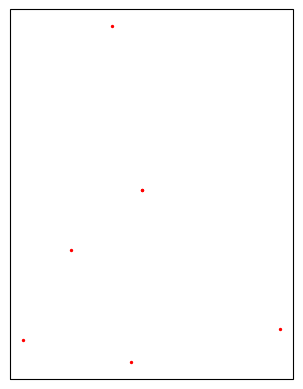

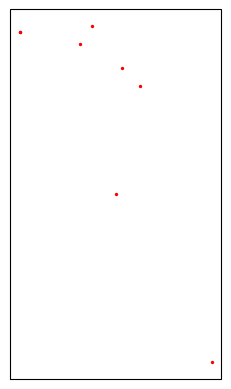

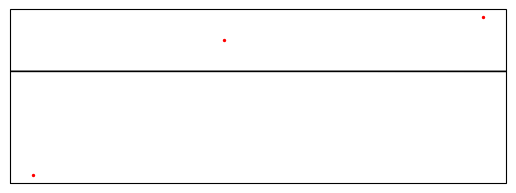

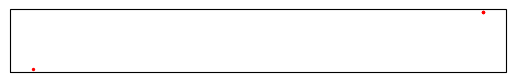

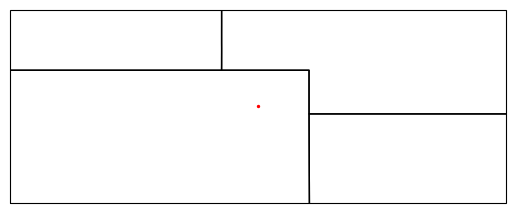

Speed             Location     County State    Lat    Lon  \
51    UNK         10 W Bradley  Lafayette    AR  33.10 -93.83   
52    UNK          7 NNE Fouke     Miller    AR  33.36 -93.85   
53    UNK    4 ENE Jenkinsburg      Butts    GA  33.35 -83.98   
54    UNK    2 WNW Hogansville      Troup    GA  33.18 -84.94   
55    UNK  1 ENE Harrisonville      Troup    GA  33.18 -84.97   
..    ...                  ...        ...   ...    ...    ...   
147   UNK         Bogue Chitto    Lincoln    MS  31.44 -90.45   
148   UNK    1 NW Bogue Chitto    Neshoba    MS  32.84 -88.94   
149   UNK    2 ESE Nanih Waiya     Kemper    MS  32.90 -88.91   
150   UNK           3 S Midway    Bullock    AL  32.03 -85.52   
151   UNK         4 WSW Rindge   Cheshire    NH  42.73 -72.10   

                                              Comments            datetime  \
51           Reports of trees down along AR 160. (SHV) 2023-06-14 18:00:00   
52                     Reports of power outages. (SHV) 2023-06-14 18:00:00   
53              Tree down along Buster Brown Rd. (FFC) 2023-06-14 18:08:00   
54   Corrects previous tstm wnd dmg report from 2 W... 2023-06-14 18:15:00   
55    Tree down on Hammett Road near Highway 54. (FFC) 2023-06-14 18:15:00   
..                                                 ...                 ...   
147  Trees and powerlines down across Neshoba and K... 2023-06-14 20:55:00   
148  Corrects location of previous tstm wnd dmg rep... 2023-06-14 20:55:00   
149  Roof blown off an outbuilding in the Coy commu... 2023-06-14 20:55:00   
150  Several trees were blown down in southeastern ... 2023-06-14 20:56:00   
151  Storm chaser reports tree branches and a 6 inc... 2023-06-14 20:58:00   

                   bins  
51  2023-06-07 18:00:00  
52  2023-06-07 18:00:00  
53  2023-06-07 18:00:00  
54  2023-06-07 18:00:00  
55  2023-06-07 18:00:00  
..                  ...  
147 2023-06-07 18:00:00  
148 2023-06-07 18:00:00  
149 2023-06-07 18:00:00  
150 2023-06-07 18:00:00  
151 2023-06-07 18:00:00  

[100 rows x 9 columns]

In [149]:
coso.reset_index()


index Speed             Location     County State    Lat    Lon  \
0       51   UNK         10 W Bradley  Lafayette    AR  33.10 -93.83   
1       52   UNK          7 NNE Fouke     Miller    AR  33.36 -93.85   
2       53   UNK    4 ENE Jenkinsburg      Butts    GA  33.35 -83.98   
3       54   UNK    2 WNW Hogansville      Troup    GA  33.18 -84.94   
4       55   UNK  1 ENE Harrisonville      Troup    GA  33.18 -84.97   
..     ...   ...                  ...        ...   ...    ...    ...   
96     147   UNK         Bogue Chitto    Lincoln    MS  31.44 -90.45   
97     148   UNK    1 NW Bogue Chitto    Neshoba    MS  32.84 -88.94   
98     149   UNK    2 ESE Nanih Waiya     Kemper    MS  32.90 -88.91   
99     150   UNK           3 S Midway    Bullock    AL  32.03 -85.52   
100    151   UNK         4 WSW Rindge   Cheshire    NH  42.73 -72.10   

                                              Comments            datetime  \
0            Reports of trees down along AR 160. (SHV) 2023-06-14 18:00:00   
1                      Reports of power outages. (SHV) 2023-06-14 18:00:00   
2               Tree down along Buster Brown Rd. (FFC) 2023-06-14 18:08:00   
3    Corrects previous tstm wnd dmg report from 2 W... 2023-06-14 18:15:00   
4     Tree down on Hammett Road near Highway 54. (FFC) 2023-06-14 18:15:00   
..                                                 ...                 ...   
96   Trees and powerlines down across Neshoba and K... 2023-06-14 20:55:00   
97   Corrects location of previous tstm wnd dmg rep... 2023-06-14 20:55:00   
98   Roof blown off an outbuilding in the Coy commu... 2023-06-14 20:55:00   
99   Several trees were blown down in southeastern ... 2023-06-14 20:56:00   
100  Storm chaser reports tree branches and a 6 inc... 2023-06-14 20:58:00   

                   bins  
0   2023-06-07 18:00:00  
1   2023-06-07 18:00:00  
2   2023-06-07 18:00:00  
3   2023-06-07 18:00:00  
4   2023-06-07 18:00:00  
..                  ...  
96  2023-06-07 18:00:00  
97  2023-06-07 18:00:00  
98  2023-06-07 18:00:00  
99  2023-06-07 18:00:00  
100 2023-06-07 18:00:00  

[101 rows x 10 columns]

In [280]:
import shapely

In [14]:
from shapely import Point, Polygon, box

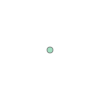

In [283]:
Point(32.03, -85.52)

In [15]:
center = [32.03, -85.52]
points = [Point(center[0] + 0.5, center[1] - 0.5), 
          Point(center[0] - 0.5, center[1] + 0.5),
          Point(center[0] + 0.5, center[1] + 0.5),
          Point(center[0] - 0.5, center[1] - 0.5)]

In [16]:
b = box(center[1] - 0.5, center[0] + 0.5,center[1] + 0.5 , center[0] - 0.5)

In [316]:
print(b)

POLYGON ((-85.02 32.53, -85.02 31.53, -86.02 31.53, -86.02 32.53, -85.02 32.53))


In [302]:
bounds(b)

array([-86.02,  31.53, -85.02,  32.53])

In [321]:
Point(32.03, -85.52).contains(b)

False

In [333]:
b.contains(Point(-85.52,32.6))

False

In [328]:
print(b.centroid)

POINT (-85.52 32.03)


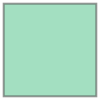

In [364]:
b

In [157]:
x,y = b.exterior.xy
ax.plot(x,y)

NameError: name 'ax' is not defined

In [366]:
x

array('d', [-85.02, -85.02, -86.02, -86.02, -85.02])

In [20]:
time = pd.Timestamp(year = 2023, month=6, day=14, hour=10)
hour = 6
dt = r.fetch_model_outputs(time, [hour, hour+1], bounding_box=b)

Finished downloading


In [21]:
dt

[<xarray.Dataset>
 Dimensions:                          (ygrid_0: 40, xgrid_0: 35, lv_ISBL0: 5,
                                       lv_AMSL1: 10, lv_HYBL2: 65, lv_SPDL3: 6,
                                       lv_ISBL4: 4, lv_HTGL5: 2, lv_SIGL6: 22,
                                       lv_SPDL7: 3, lv_HTGL8: 2, lv_DBLL9: 9,
                                       lv_HTGL10: 2, lv_HTGL11: 2, lv_HTGL12: 2)
 Coordinates:
   * lv_HTGL12                        (lv_HTGL12) float32 1.0 2.0
   * lv_SIGL6                         (lv_SIGL6) float32 0.053 0.158 ... 0.9975
   * lv_HTGL5                         (lv_HTGL5) float32 2.0 10.0
   * lv_ISBL4                         (lv_ISBL4) float32 2.5e+04 ... 8.5e+04
   * lv_HYBL2                         (lv_HYBL2) float32 1.0 2.0 ... 64.0 65.0
   * lv_AMSL1                         (lv_AMSL1) float32 305.0 ... 4.572e+03
   * lv_ISBL0                         (lv_ISBL0) float32 2.5e+04 ... 9.5e+04
     gridlat_0                        (ygrid_0, xg